### Example about how to apply classes in NgramCorpus.py
- add tested functions `get_ttr`,`get_rare_report`,`get_rare_txt` in class `CorpusCompareReport` to find rare ngram span, fixed some rare occured bug.
- test on the second artificial corpus named A2, generated from R1 by a french model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re,time,os,json
from pathlib import Path
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from NgramCorpus import NgramCorpus, CorpusCompare,CorpusCompareReport,CorpusCompareList
from NgramCorpus import get_common_text_singleN,tokenizer_fr, get_details_from_tsv

In [3]:

#code copy from information retrieval TP
# this turns on the autotimer, so that every cell has a timing information below
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
# stop using:
# %unload_ext autotime

time: 386 µs (started: 2022-05-10 20:28:27 +02:00)


>In resFolder, <br>
a folder named {name_prefix}\_{n_start}\_to\_{max_n}'  (e.g. A vs R_1_to_8)
will be created if we run the method "CorpusCompare.ngram_info" with storage mode 
<br>another folder named "ngram_common" will be created in this folder to store ngram in common for n from n_start to max_n


In [4]:
#create a result folder, should import Path from pathlib
resFolder = "res_report" 
Path(resFolder).mkdir(parents=True, exist_ok=True)


time: 2.04 ms (started: 2022-05-10 20:28:27 +02:00)


In [5]:
'A vs R_1_to_10'.split('_')[:-3]

['A vs R']

time: 10.5 ms (started: 2022-05-10 20:28:27 +02:00)


## Load Data 

Put text data in a dictionary with key = filename, values = relevant text.<br> We can also put together all the file as a single text string, otherwise the class NgramCorpus will do this job when creating the instance with the data in dictionary.


In [6]:
#the preprocessing function for our dataset 
from prepro import prepro 

time: 4.23 ms (started: 2022-05-10 20:28:27 +02:00)


#### Original corpus R1 (E3C-Fr) used to generate artificial corpus A

In [7]:
dataPath = "data/E3C-French/"#"E3C-French/"
#test
# origin1 = open(dataPath + "layer3_top200Ktokens.txt").read()

#R1 E3C
corpusR1_file = {}
corpusR1_txt = ""

files_r1 = os.listdir(dataPath + "layer3/")

for fname in files_r1:
    if(fname[:2] == 'FR'):
        #print(fname)
        with open(dataPath + "layer3/" +fname, 'r') as f:
            ft = json.load(f)
            if ft["type"] in ["pubmed", "journal"]:
                cleaned = prepro(ft['text'])
                corpusR1_file[fname] = ' \n '+cleaned
                corpusR1_txt += ' \n '+cleaned

print(corpusR1_txt[:150])
print(len(corpusR1_file))

 
 Il s'agit d'une patiente âgée de 41 ans, sans antécédents pathologiques particuliers qui a consulté en consultation neurochirurgie pour une exophta
760
time: 3.83 s (started: 2022-05-10 20:28:28 +02:00)


#### Another real clinical corpus R2 (DEFT)

In [8]:
#R2 DEFT

corpusR2_txt = ""
corpusR2_file = {}

files_r2 = os.listdir("data/DEFT-cas-cliniques_txt")

for fname in files_r2:
    ft = open("data/DEFT-cas-cliniques_txt/"+fname).read()
    cleaned = ' \n '+ prepro(ft)
    corpusR2_txt += cleaned
    corpusR2_file[fname] = cleaned
    

print(corpusR2_txt[:150])

 
 On a diagnostiqué, chez une patiente, une leucémie aiguë lymphoblastique à l’âge de sept ans. Elle a été traitée selon le protocole Boston 1995. En
time: 137 ms (started: 2022-05-10 20:28:32 +02:00)


#### Artificial corpus A, generated from R1 
- by a model pretrained for English, fine-tuned for French, temperature <=1

In [9]:
# artificial corpus

#whole
corpusA_txt = ""
corpusA_file = {}

docs_gen =  os.listdir(dataPath + "GPT2/")
docs_gen.remove('samples')
for doc in docs_gen:
    print("reading artificial corpus ", doc)
    files = os.listdir(dataPath + "GPT2/"+ doc +'/')
    txt = ""
    for f in files:
        ft = prepro(open(dataPath + "GPT2/"+ doc +'/'+f).read())
        corpusA_txt += ' \n '+ft
        txt+= ' \n '+ft
    corpusA_file[doc] = txt

reading artificial corpus  gen_temp0.8
reading artificial corpus  gen_temp0.6
reading artificial corpus  gen_temp0.7
reading artificial corpus  gen_temp1
reading artificial corpus  gen_temp0.5
reading artificial corpus  gen_temp0.3
reading artificial corpus  gen_temp0.9
time: 41.1 ms (started: 2022-05-10 20:28:32 +02:00)


#### Another artificial corpus A2 generated from R1 
- by a model trained for French, temperature <= 1

In [10]:
corpusA2_txt = open("data/gpt2_fr_e3c_temp=1.txt").read()
corpusA2_file = {"gpt2_fr_e3c_temp=1.txt": corpusA2_txt}
corpusA2_txt[:150]

'S.A. est un garçon âgé de 4 ans qui n’a eu aucun antécédent pathologique médical ni chirurgical particulier, sans notion d’hospitalisation durant la p'

time: 11.5 ms (started: 2022-05-10 20:28:32 +02:00)


#### Another artificial corpus A3 generated from R1 
- by the same model as A2, temperature in [1,1.5]

In [11]:
corpusA3_txt = open("data/gpt2_fr_e3c.txt").read()
corpusA3_file = {"gpt2_fr_e3c.txt": corpusA3_txt}
corpusA3_txt[:150]

'S.A. est un nourrisson âgée de 5 mois de sexe masculin issu d’une grossesse menée à terme sans incidents. Il n’a pas d’antécédents médicaux ou chirurg'

time: 6.5 ms (started: 2022-05-10 20:28:32 +02:00)


## NgramCorpus & CorpusCompare

In [12]:
#creat instance NgramCorpus
#by default #tokenizer = tokenizer_fr,resFolder = 'res_report'
corpusA = NgramCorpus(corpusA_file, corpusA_txt) 
corpusA2 = NgramCorpus(corpusA2_file, corpusA2_txt)
corpusA3 = NgramCorpus(corpusA3_file, corpusA3_txt)

corpusR1 = NgramCorpus(corpusR1_file, corpusR1_txt) 
corpusR2 = NgramCorpus(corpusR2_file, corpusR2_txt)

time: 1.33 ms (started: 2022-05-10 20:28:32 +02:00)


In [13]:
#creat instance CorpusCompare
#by default resFolder = 'res_report', all results will be stored there 

#Corpus A, generated by a model trained for English then fine tuned for French, temperature < 1
corpusCompareAR1 = CorpusCompare(corpusA, corpusR1, resFolder = 'res_report')
corpusCompareAR2 = CorpusCompare(corpusA, corpusR2)
corpusCompareR12 = CorpusCompare(corpusR1, corpusR2)

#Corpus A2, generated by a model trained for French, temperature < 1
corpusCompareA2R1 =  CorpusCompare(corpusA2, corpusR1)
corpusCompareA2R2 = CorpusCompare(corpusA2, corpusR2)
corpusCompareA2A = CorpusCompare(corpusA2, corpusA)

#Corpus A3, generated by the same model as that of A2, temperature in [1, 1.5]
corpusCompareA3R1 =  CorpusCompare(corpusA3, corpusR1)
corpusCompareA3R2 = CorpusCompare(corpusA3, corpusR2)
corpusCompareA3A = CorpusCompare(corpusA3, corpusA)

#A2 vs A3 & A3 vs A2
corpusCompareA3A2 = CorpusCompare(corpusA3, corpusA2)
corpusCompareA2A3 = CorpusCompare(corpusA2, corpusA3)


time: 2.28 ms (started: 2022-05-10 20:28:33 +02:00)


### Find longest match 

##### corpus A
- A vs R1

In [14]:
#find longest match between corpus A and corpus R1
longestAR1 = corpusCompareAR1.find_longest_common(filename = 'longest_matchAR1.tsv')

looking for common text in 8gram
---- got 367 8gram
looking for common text in 16gram
---- got 3 16gram
looking for common text in 24gram
0 24gram in common
looking for common text in 20gram
0 20gram in common
looking for common text in 18gram
0 18gram in common
looking for common text in 17gram
The longest match found in 17gram
time: 46.9 s (started: 2022-05-09 18:54:40 +02:00)


In [15]:
longestAR1 

,text_common,freq_c0,freq_c1
0,une formation hypoéchogène hétérogène de contours irréguliers renfermant des zones kystiques et prenant fortement le...,2,1


time: 8.97 ms (started: 2022-05-09 18:55:27 +02:00)


In [15]:
#check if there is only one 17gram in common and no more longer ngram in common
test_df = corpusCompareAR1.ngram_info( n_start = 15, max_n = 19, info ='A vs R1' , store = False)
test_df.get_freq_report()

computing ngram in common with n in range [15,19]
done with 14.739064693450928s, analysing result for each n 
There are  7 15gram in both corpus. Coverage of A to R is 0.00013398924257795303
There are  3 16gram in both corpus. Coverage of A to R is 5.74052812858783e-05
There are  1 17gram in both corpus. Coverage of A to R is 1.9129237126023413e-05
There are  0 18gram in both corpus. Coverage of A to R is 0.0
There are  0 19gram in both corpus. Coverage of A to R is 0.0
done with 8.736561059951782s


,15gram,16gram,17gram,18gram,19gram
length,7,3,1,0,0


time: 23.5 s (started: 2022-05-03 01:05:05 +02:00)


- Others<br>
AR2, R1R2

In [15]:
#Same for corpus A and R2
longestAR2 = corpusCompareAR2.find_longest_common(filename = '/longest_matchAR2.tsv')

looking for common text in 8gram
---- got 43 8gram
looking for common text in 16gram
0 16gram in common
looking for common text in 12gram
0 12gram in common
looking for common text in 10gram
---- got 7 10gram
looking for common text in 11gram
The longest match found in 11gram
time: 40.5 s (started: 2022-05-03 01:07:54 +02:00)


In [17]:
longestAR2 

,text_common,freq_c0,freq_c1
0,Il agit un patient âgé de 36 ans sans antécédents pathologiques,1,1
1,sans antécédents pathologiques particuliers qui est présentée aux urgences pour un,1,1


time: 6.48 ms (started: 2022-05-03 01:06:08 +02:00)


In [17]:
#R1 vs R2 
longestR12 = corpusCompareR12.find_longest_common(filename = '/longest_matchR12.tsv')

looking for common text in 8gram
---- got 353 8gram
looking for common text in 16gram
---- got 77 16gram
looking for common text in 24gram
---- got 39 24gram
looking for common text in 32gram
---- got 23 32gram
looking for common text in 40gram
---- got 7 40gram
looking for common text in 48gram
0 48gram in common
looking for common text in 44gram
---- got 3 44gram
looking for common text in 46gram
The longest match found in 46gram
time: 1min 46s (started: 2022-05-03 01:10:24 +02:00)


In [18]:
display(longestR12)
longestR12.text_common.values

,text_common,freq_c0,freq_c1
0,de la CEC est faite entre une canule artérielle au pied du TABC et deux canules veineuses bi-caves et menée en hypot...,1,1


array(['de la CEC est faite entre une canule artérielle au pied du TABC et deux canules veineuses bi-caves et menée en hypothermie modérée La protection myocardique est assurée par une cardioplégie cristalloïde froide intermittente antérograde Une atriotomie gauche derrière le sillon de SONDERGAARD est réalisée permettant'],
      dtype=object)

time: 66.2 ms (started: 2022-05-03 01:12:10 +02:00)


##### Corpus A2
- A2 vs R1, A2 vs R2, A2 vs A

In [15]:
name_list_a2 = ['A2R1', 'A2R2', 'A2A']
longest_a2 = {}
for i, cp in enumerate([corpusCompareA2R1, corpusCompareA2R2, corpusCompareA2A]):
    key = name_list_a2[i]
    print(f'\033[1mcorpus{key}\033[0m')
    longest_a2[key] = cp.find_longest_common(filename = f'/longest_match{key}.tsv')

corpusA2R1
looking for common text in 8gram
---- got 443 8gram
looking for common text in 16gram
---- got 208 16gram
looking for common text in 24gram
---- got 104 24gram
looking for common text in 32gram
---- got 70 32gram
looking for common text in 40gram
---- got 43 40gram
looking for common text in 48gram
---- got 19 48gram
looking for common text in 56gram
---- got 4 56gram
looking for common text in 64gram
0 64gram in common
looking for common text in 60gram
0 60gram in common
looking for common text in 58gram
---- got 2 58gram
looking for common text in 59gram
The longest match found in 59gram
corpusA2R2
looking for common text in 8gram
---- got 24 8gram
looking for common text in 16gram
0 16gram in common
looking for common text in 12gram
---- got 3 12gram
looking for common text in 14gram
The longest match found in 14gram
corpusA2A
looking for common text in 8gram
---- got 14 8gram
looking for common text in 16gram
0 16gram in common
looking for common text in 12gram
0 12gram 

In [16]:
for ky, longest in longest_a2.items():
    print(f'\033[1mcorpus{ky}\033[0m')
    print(f"longest match in {ky}:\n",longest.text_common.values)
    display(longest)

corpusA2R1
longest match in A2R1:
 ['est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion hospitalisation durant la période néonatale avec un bon développement psychomoteur et un statut vaccinal complet selon le programme élargi de vaccination du Sénégal Il est le 4 ème une fratrie de 5 enfants ses frères et sœurs sont vivants et bien']


,text_common,freq_c0,freq_c1
0,est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion hospi...,72,1


corpusA2R2
longest match in A2R2:
 ['radiographie du thorax montré une silhouette cardiaque de taille normale et une bonne transparence']


,text_common,freq_c0,freq_c1
0,radiographie du thorax montré une silhouette cardiaque de taille normale et une bonne transparence,1,1


corpusA2A
longest match in A2A:
 ['La radiographie du thorax mis en évidence une cardiomégalie avec un']


,text_common,freq_c0,freq_c1
0,La radiographie du thorax mis en évidence une cardiomégalie avec un,1,1


time: 25.7 ms (started: 2022-05-07 23:21:23 +02:00)


##### Corpus A3
- A3 vs R1, A3 vs R2, A3 vs A

In [17]:
name_list_a3 = ['A3R1', 'A3R2', 'A3A']
longest_a3 = {}
for i, cp in enumerate([corpusCompareA3R1, corpusCompareA3R2, corpusCompareA3A]):
    key = name_list_a3[i]
    print(f'\033[1mcorpus{key}\033[0m')
    longest_a3[key] = cp.find_longest_common(filename = f'/longest_match{key}.tsv')

corpusA3R1
looking for common text in 8gram
---- got 1305 8gram
looking for common text in 16gram
---- got 407 16gram
looking for common text in 24gram
---- got 145 24gram
looking for common text in 32gram
---- got 44 32gram
looking for common text in 40gram
---- got 20 40gram
looking for common text in 48gram
---- got 12 48gram
looking for common text in 56gram
---- got 4 56gram
looking for common text in 64gram
0 64gram in common
looking for common text in 60gram
0 60gram in common
looking for common text in 58gram
---- got 2 58gram
looking for common text in 59gram
The longest match found in 59gram
corpusA3R2
looking for common text in 8gram
---- got 36 8gram
looking for common text in 16gram
0 16gram in common
looking for common text in 12gram
0 12gram in common
looking for common text in 10gram
---- got 5 10gram
looking for common text in 11gram
The longest match found in 11gram
corpusA3A
looking for common text in 8gram
---- got 32 8gram
looking for common text in 16gram
0 16gram

In [18]:
for ky, longest in longest_a3.items():
    print(f'\033[1mcorpus{ky}\033[0m')
    print(f"longest match in {ky}:\n",longest.text_common.values)
    display(longest)

corpusA3R1
longest match in A3R1:
 ['est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion hospitalisation durant la période néonatale avec un bon développement psychomoteur et un statut vaccinal complet selon le programme élargi de vaccination du Sénégal Il est le 4 ème une fratrie de 5 enfants ses frères et sœurs sont vivants et bien']


,text_common,freq_c0,freq_c1
0,est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion hospi...,11,1


corpusA3R2
longest match in A3R2:
 ['examen pleuro-pulmonaire et le reste de examen somatique sont sans particularités'
 'évoluant dans un contexte altération de état général et amaigrissement chiffré']


,text_common,freq_c0,freq_c1
0,examen pleuro-pulmonaire et le reste de examen somatique sont sans particularités,1,1
1,évoluant dans un contexte altération de état général et amaigrissement chiffré,1,1


corpusA3A
longest match in A3A:
 ["s'agit d'un patient âgé de 37 ans sans antécédent pathologique"]


,text_common,freq_c0,freq_c1
0,s'agit d'un patient âgé de 37 ans sans antécédent pathologique,2,1


time: 474 ms (started: 2022-05-07 23:36:39 +02:00)


##### Others: A3 vs A2

In [14]:
longestA3A2 = corpusCompareA3A2.find_longest_common(filename = '/longest_matchA3A2.tsv')

looking for common text in 8gram
---- got 615 8gram
looking for common text in 16gram
---- got 450 16gram
looking for common text in 24gram
---- got 360 24gram
looking for common text in 32gram
---- got 315 32gram
looking for common text in 40gram
---- got 290 40gram
looking for common text in 48gram
---- got 269 48gram
looking for common text in 56gram
---- got 223 56gram
looking for common text in 64gram
---- got 177 64gram
looking for common text in 72gram
---- got 134 72gram
looking for common text in 80gram
---- got 102 80gram
looking for common text in 88gram
---- got 70 88gram
looking for common text in 96gram
---- got 41 96gram
looking for common text in 104gram
---- got 15 104gram
looking for common text in 112gram
The longest match found in 112gram
time: 17.2 s (started: 2022-05-07 23:44:09 +02:00)


In [16]:
print(f"longest match in A3A2:\n",longestA3A2.text_common.values)
longestA3A2

longest match in A3A2:
 ['S.A. est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion hospitalisation durant la période néonatale avec un bon développement psychomoteur et un statut vaccinal complet selon le programme élargi de vaccination du Sénégal Il est le 4 ème une fratrie de 5 enfants ses frères et sœurs sont vivants et bien portants.\\nIl été reçu dans notre service pour hématémèse de grande abondance méléna et vertiges chez qui examen notait un syndrome anémique et un syndrome hémorragique avec une vitesse de sédimentation 108 mm la 1 ère heure mais il pas présenté de baisse de acuité visuelle Les examens biologiques ont objectivé une anémie']


,text_common,freq_c0,freq_c1
0,S.A. est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion ...,1,2


time: 5.98 ms (started: 2022-05-07 23:45:44 +02:00)


##### Comments

>we found that the longest ngram in common among pair of corpus in [A, A2, A3, R1, R2] is a 112gram between A2 and A3, Then the pair (A2, R1) and (A3, R1) have the same longest match in common pf length 59.
>We may guess that the seconde model knows more to copy the original corpus, and the corpus generated by the same model are more similar to each other than other corpus.
>In the following section, we explore more about the pair (A2, R1)
<br>From the output log, we notice that there's no other ngram in common for (A3,R1) with `n >= 40` since there are only 20 40gram, but other 48grams exist for (A2R1) since there are 19 48gram<br>


In [14]:
print('nbr of char in R1:', len(corpusR1_txt))
print('nbr of char in R2:', len(corpusR2_txt))
print('nbr of char in A2:', len(corpusA2_txt))
print('nbr of char in A :', len(corpusA_txt))
print('nbr of char in A3 :', len(corpusA3_txt))

nbr of char in R1: 1703732
nbr of char in R2: 1428893
nbr of char in A2: 378720
nbr of char in A : 381276
nbr of char in A3 : 396144
time: 1.84 ms (started: 2022-05-10 20:28:39 +02:00)


In [15]:
import pandas as pd
longest_A2R1 = pd.read_csv("res_report/longest_matchA2R1.tsv", sep = '\t', index_col = 0)
longest_A2R1

,text_common,freq_c0,freq_c1
0,est un garçon âgé de 4 ans qui eu aucun antécédent pathologique médical ni chirurgical particulier sans notion hospi...,72,1


time: 20.1 ms (started: 2022-05-10 02:34:07 +02:00)


- find the longest match of A2 vs R1 in R1

In [16]:
fcom_a2r1, fcom_a2r1_f2s = corpusR1.get_distribution_common(list(longest_A2R1.text_common.values))
print(fcom_a2r1)
print(fcom_a2r1_f2s)

{0: ['FR101481.json']}
{'FR101481.json': [0]}
time: 1.62 s (started: 2022-05-10 02:34:07 +02:00)


>Since the most long match between A & R1 is a 17gram, we look for the 17gram in common between A2&R1:

In [17]:
test_gram17, _, _ = corpusCompareA2R1.get_common_stat(colname = "17gram", nrange = (17,17))
print(f"There are {len(test_gram17)} 17gram")
test_gram17.sort_values('freq_c0', ascending = False)

There are 190 17gram


,17gram,freq_c0,freq_c1,percent_c0,percent_c1,percent_common_c0
189,été reçu dans notre service pour hématémèse de grande abondance méléna et vertiges chez qui examen notait,94,1,0.002005,0.000004,0.016535
84,grande abondance méléna et vertiges chez qui examen notait un syndrome anémique et un syndrome hémorragique avec,94,1,0.002005,0.000004,0.016535
23,antécédent pathologique médical ni chirurgical particulier sans notion hospitalisation durant la période néonatale a...,94,1,0.002005,0.000004,0.016535
26,aucun antécédent pathologique médical ni chirurgical particulier sans notion hospitalisation durant la période néona...,94,1,0.002005,0.000004,0.016535
27,avec un bon développement psychomoteur et un statut vaccinal complet selon le programme élargi de vaccination du,94,1,0.002005,0.000004,0.016535
...,...,...,...,...,...,...
148,sa virginité et adressée par la suite un médecin neurologue Une IRM cérébrale s'est révélée normale tandis,1,1,0.000021,0.000004,0.000176
41,cérébrale s'est révélée normale tandis que l'EEG de veille été de type comitial décharges de pointes frontales,1,1,0.000021,0.000004,0.000176
155,suite un médecin neurologue Une IRM cérébrale s'est révélée normale tandis que l'EEG de veille été de,1,1,0.000021,0.000004,0.000176
157,sédimentation était 55 mm la 1ère heure la protéine réactive était 6 mg/l La numération formule sanguine,1,1,0.000021,0.000004,0.000176


time: 7.56 s (started: 2022-05-10 02:34:32 +02:00)


In [18]:
test_gram17.sort_values('freq_c1', ascending = False)

,17gram,freq_c0,freq_c1,percent_c0,percent_c1,percent_common_c0
0,2 enfants son petit frère était en bon état apparent de santé il avait pas de malformation,7,1,0.000149,0.000004,0.001231
130,présente des difficultés maintenir la position debout L'examen du pied révélé un pied gauche malformé avec une,23,1,0.000490,0.000004,0.004046
121,patient été nourris exclusivement au sein jusqu 12 mois examen clinique le patient présente un état général,19,1,0.000405,0.000004,0.003342
122,pied révélé un pied gauche malformé avec une tuméfaction et une syndactylie des 2 et 3 orteils,23,1,0.000490,0.000004,0.004046
123,pointes frontales et temporales prédominantes droite La patiente alors été mise sous carbamazépine la dose de 600,3,1,0.000064,0.000004,0.000528
...,...,...,...,...,...,...
65,en consultation pour la prise en charge de sa fente labio-palatine Son père 33 ans informaticien et,7,1,0.000149,0.000004,0.001231
66,en vie et les deux parents sont également en vie et en bonne santé apparente Sa mère,1,1,0.000021,0.000004,0.000176
67,enfant est cadet une fratrie de 9 dont 3 décès la suite épisodes infectieux non déterminés Les,19,1,0.000405,0.000004,0.003342
68,enfants son petit frère était en bon état apparent de santé il avait pas de malformation dans,7,1,0.000149,0.000004,0.001231


time: 11.8 ms (started: 2022-05-10 02:34:40 +02:00)


>If we try to compute the statistic from 36 gram to 56gram


In [19]:
#you may don't want to rerun this cell, too time-consumming
test_df = corpusCompareA2R1.ngram_info( n_start = 36, max_n = 50, info ='A2 vs R1' , store = False)
test_df.get_freq_report()

computing ngram in common with n in range [36,50]
done with 51.21932291984558s, analysing result for each n 
There are  55 36gram in both corpus. Coverage of A to R is 0.0016318537859007832
There are  52 37gram in both corpus. Coverage of A to R is 0.0015341043190936984
There are  49 38gram in both corpus. Coverage of A to R is 0.0014374981664564204
There are  46 39gram in both corpus. Coverage of A to R is 0.0013420077603057445
There are  43 40gram in both corpus. Coverage of A to R is 0.0012476063366796263
There are  40 41gram in both corpus. Coverage of A to R is 0.0011542345981820806
There are  37 42gram in both corpus. Coverage of A to R is 0.0010619367430113082
There are  34 43gram in both corpus. Coverage of A to R is 0.0009706797613269763
There are  31 44gram in both corpus. Coverage of A to R is 0.0008803816880608883
There are  28 45gram in both corpus. Coverage of A to R is 0.000791072185336912
There are  25 46gram in both corpus. Coverage of A to R is 0.0007026814323458317
T

,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
length,55,52,49,46,43,40,37,34,31,28,25,22,19,16,13


time: 3min 1s (started: 2022-05-10 02:34:43 +02:00)


In [20]:
testA2R1 = test_df.get_coverage()

testA2R1_normed = test_df.get_normed_freq() #recouvrement
print('\033[1mcoverage & recouvrement \033[0m')
display(testA2R1)
display(testA2R1_normed)

print("\033[1mcommon text rare in R1\033[0m" )
rarerepo_testA2R1 = test_df.get_rare_report(k = 5)


coverage & recouvrement 


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
couverture_A2 vs R1,0.001632,0.001534,0.001437,0.001342,0.001248,0.001154,0.001062,0.000971,0.00088,0.000791,0.000703,0.000615,0.000529,0.000443,0.000358


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
recouvrement_A2 vs R1,0.000201,0.00019,0.000179,0.000168,0.000157,0.000146,0.000135,0.000124,0.000113,0.000102,0.000091,0.00008,0.000069,0.000058,0.000047


common text rare in R1
K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
len_k5,55,52,49,46,43,40,37,34,31,28,25,22,19,16,13


total nomber of ngram set for each n:


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
length,55,52,49,46,43,40,37,34,31,28,25,22,19,16,13


time: 112 ms (started: 2022-05-10 02:37:45 +02:00)


In [21]:
print("\033[1mcommon text rare in R1\033[0m" )
rarerepo_testA2R1 = test_df.get_rare_report(k = 1)

common text rare in R1
K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
len_k1,55,52,49,46,43,40,37,34,31,28,25,22,19,16,13


total nomber of ngram set for each n:


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
length,55,52,49,46,43,40,37,34,31,28,25,22,19,16,13


time: 32 ms (started: 2022-05-10 02:37:45 +02:00)


> We found that all the ngram in common with n>=36 between A2 and R1 are rare in R1 at the level of k = 1

In [15]:
#you may don't want to rerun this cell, too time-consumming
test_df = corpusCompareA3R1.ngram_info( n_start = 36, max_n = 50, info ='A3 vs R1' , store = False)
# test_df.get_freq_report()

computing ngram in common with n in range [36,50]
done with 68.80670523643494s, analysing result for each n 
There are  26 36gram in both corpus. Coverage of A to R is 0.0005283049538749137
There are  23 37gram in both corpus. Coverage of A to R is 0.0004668723611562195
There are  22 38gram in both corpus. Coverage of A to R is 0.00044612077706128076
There are  21 39gram in both corpus. Coverage of A to R is 0.00042542846724200804
There are  20 40gram in both corpus. Coverage of A to R is 0.0004047927461139896
There are  19 41gram in both corpus. Coverage of A to R is 0.00038420318282005137
There are  18 42gram in both corpus. Coverage of A to R is 0.0003636804461146806
There are  17 43gram in both corpus. Coverage of A to R is 0.0003431916826486323
There are  16 44gram in both corpus. Coverage of A to R is 0.00032273680813296756
There are  15 45gram in both corpus. Coverage of A to R is 0.0003023218316672041
There are  14 46gram in both corpus. Coverage of A to R is 0.0002819340677044

In [16]:
print("\033[1mcommon text rare in R1\033[0m" )
rarerepo_testA3R1 = test_df.get_rare_report(k = 5)

common text rare in R1
K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
len_k5,26,23,22,21,20,19,18,17,16,15,14,13,12,11,10


total nomber of ngram set for each n:


,36gram,37gram,38gram,39gram,40gram,41gram,42gram,43gram,44gram,45gram,46gram,47gram,48gram,49gram,50gram
length,26,23,22,21,20,19,18,17,16,15,14,13,12,11,10


time: 180 ms (started: 2022-05-10 20:32:20 +02:00)


### ngram info from 1 to 8

In [16]:
n_start = 1
max_n = 8
prefix = "A vs R1"

time: 10.1 ms (started: 2022-05-09 18:55:27 +02:00)


In [17]:
#compute and store ngram info in resfolder
detailAR1 = corpusCompareAR1.ngram_info( n_start = n_start, max_n = max_n, info = prefix , store = True)

computing ngram in common with n in range [1,8]
done with 19.755610466003418s, analysing result for each n 
There are  4977 1gram in both corpus. Coverage of A to R is 0.6785276073619632
There are  10944 2gram in both corpus. Coverage of A to R is 0.42515830775805136
There are  9172 3gram in both corpus. Coverage of A to R is 0.23354467445827923
There are  5484 4gram in both corpus. Coverage of A to R is 0.11954223433242507
There are  2938 5gram in both corpus. Coverage of A to R is 0.06005846399149615
There are  1498 6gram in both corpus. Coverage of A to R is 0.029691588044081504
There are  747 7gram in both corpus. Coverage of A to R is 0.014573619212985544
There are  367 8gram in both corpus. Coverage of A to R is 0.007104830122930984
done with 10.503820657730103s
writing results in res_report/A vs R1_1_to_8
time: 30.6 s (started: 2022-05-09 18:55:27 +02:00)


#### Read ngram_info stored in resFolder

In [18]:
#folder stored ngram info for A R1 from n_start to max_n
#res_folder = resFolder+f"/{prefix}_{n_start}_to_{max_n}"
res_folder = resFolder +'/A vs R1_1_to_8'

time: 594 µs (started: 2022-05-09 18:55:58 +02:00)


>CREAT CorpusCompareReport FROM NGRAM_INFO STORED IN res_folder 

In [19]:
#creat CorpusCompareReport from ngram_info stored in res_folder 
detailAR1 = CorpusCompareReport.fromFolder(res_folder)

time: 109 ms (started: 2022-05-09 18:55:58 +02:00)


In [20]:
#read the ngram info from a folder in res_folder 
detail_dict = get_details_from_tsv(res_folder)
print(detail_dict.keys())
display(detail_dict['1gram'].head(3))
print('coverage and recouvrement')
pd.read_csv(res_folder+ f'/cover_recouv.tsv', sep = '\t', index_col = 0)#.loc[['couverture_A vs R1']]

dict_keys(['4gram', '1gram', '3gram', '2gram', '6gram', '7gram', '5gram', '8gram'])


,1gram,freq_c0,freq_c1,percent_c0,percent_c1,percent_common_c0
0,de,2844,13707,0.053845,0.057005,0.056849
1,une,2163,6477,0.040952,0.026937,0.043237
2,la,1373,6492,0.025995,0.026999,0.027445


coverage and recouvrement


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R1,0.678528,0.425158,0.233545,0.119542,0.060058,0.029692,0.014574,0.007105
recouvrement_A vs R1,0.207013,0.090015,0.043764,0.021515,0.010690,0.005283,0.002599,0.001269


time: 89 ms (started: 2022-05-09 18:55:58 +02:00)


In [21]:
#use method of class CorpusCompareReport:
display(detailAR1.get_coverage())

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R1,0.678528,0.425158,0.233545,0.119542,0.060058,0.029692,0.014574,0.007105


time: 7.45 ms (started: 2022-05-09 18:55:58 +02:00)


In [22]:
detailAR1.get_normed_freq()#le recouvrement

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs R1,0.207013,0.090015,0.043764,0.021515,0.01069,0.005283,0.002599,0.001269


time: 13.5 ms (started: 2022-05-09 18:55:58 +02:00)


##### The rare matches 
>rare in corpus R1 for corposCompareAR1

In [23]:
rare_dict = detailAR1.get_rare_txt(k = 1)
rare_dict['6gram']

,6gram,freq_c0,freq_c1,percent_c0,percent_c1,percent_common_c0
7,Le diagnostic de syndrome de Guillain,10,1,0.000189,0.000004,0.004232
8,diagnostic de syndrome de Guillain Barrée,10,1,0.000189,0.000004,0.004232
13,Le bilan biologique retrouve une hyperleucocytose,9,1,0.000170,0.000004,0.003809
20,L'évolution était marquée par une amélioration,8,1,0.000151,0.000004,0.003386
26,de syndrome de Guillain Barrée était,7,1,0.000133,0.000004,0.002962
...,...,...,...,...,...,...
1492,de grand axe compatible avec une,1,1,0.000019,0.000004,0.000423
1493,de fièvre ni d'altération de l'état,1,1,0.000019,0.000004,0.000423
1495,de douleurs abdominales type de coliques,1,1,0.000019,0.000004,0.000423
1496,de contage tuberculeux ni de notion,1,1,0.000019,0.000004,0.000423


time: 18.5 ms (started: 2022-05-09 18:55:58 +02:00)


In [24]:
rare_report = detailAR1.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,558,2917,3630,2846,1810,1046,566,298


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,4977,10944,9172,5484,2938,1498,747,367


time: 16.7 ms (started: 2022-05-09 18:55:58 +02:00)


##### number of ngrams

In [25]:
#length of ngram_df
freq_df = detailAR1.get_freq_report()
freq_df

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,4977,10944,9172,5484,2938,1498,747,367


time: 6.03 ms (started: 2022-05-09 18:55:58 +02:00)


In [26]:
#number of different ngrams 
diver_df = detailAR1.get_len_all() 
diver_df 

,len_A,len_R,len_all
1gram,7335,21684,24042
2gram,25741,106783,121580
3gram,39273,179480,209581
4gram,45875,214497,254888
5gram,48919,228861,274842
6gram,50452,234604,283558
7gram,51257,236938,287448
8gram,51655,237921,289209


time: 16.4 ms (started: 2022-05-09 18:55:58 +02:00)


##### The type/token ratio

,ttr_A,ttr_R,ttr_all
1gram,0.138873,0.090180,0.081979
2gram,0.487362,0.444093,0.414568
3gram,0.743581,0.746431,0.714642
4gram,0.868598,0.892065,0.869139
5gram,0.926251,0.951807,0.937186
6gram,0.955295,0.975695,0.966913
7gram,0.970556,0.985406,0.980185
8gram,0.978111,0.989499,0.986196


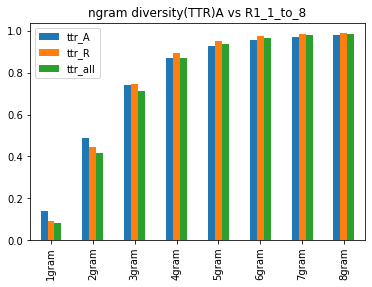

time: 358 ms (started: 2022-05-09 18:55:58 +02:00)


In [27]:
normed_diver = detailAR1.get_ttr( imgName = f'/diver_ngram(TTR){n_start}_{max_n}.png' ) #show and store figure 
normed_diver.rename(columns = {'len_A': 'normed_len_A', 'len_R': 'normed_len_R', 'len_all': 'normed_len_all'}, inplace=True)
normed_diver

#### If replace number by NUM?

In [36]:
dataPath = "data/E3C-French/"#"E3C-French/"
#original corpus

#R1 E3C
corpusR1_file_num = {}
corpusR1_txt_num = ""

files_r1 = os.listdir(dataPath + "layer3/")

for fname in files_r1:
    if(fname[:2] == 'FR'):
        #print(fname)
        with open(dataPath + "layer3/" +fname, 'r') as f:
            ft = json.load(f)
            if ft["type"] in ["pubmed", "journal"]:
                cleaned = prepro(ft['text'], keep_num = False)
                corpusR1_file_num[fname] = ' \n '+cleaned
                corpusR1_txt_num += ' \n '+cleaned

print(corpusR1_txt_num[:150])
print(len(corpusR1_file_num))

 
 Il s'agit d'une patiente âgée de NUM  ans, sans antécédents pathologiques particuliers qui a consulté en consultation neurochirurgie pour une exoph
760
time: 3.66 s (started: 2022-05-03 01:41:19 +02:00)


In [37]:
# artificial corpus
#whole
corpusA_txt_num = ""
corpusA_file_num = {}

docs_gen =  os.listdir(dataPath + "GPT2/")
docs_gen.remove('samples')
for doc in docs_gen:
    print("reading artificial corpus ", doc)
    files = os.listdir(dataPath + "GPT2/"+ doc +'/')
    txt = ""
    for f in files:
        ft = prepro(open(dataPath + "GPT2/"+ doc +'/'+f).read(), keep_num= False)
        corpusA_txt_num += ' \n '+ft
        txt+= ' \n '+ft
    corpusA_file_num[doc] = txt

reading artificial corpus  gen_temp0.8
reading artificial corpus  gen_temp0.6
reading artificial corpus  gen_temp0.7
reading artificial corpus  gen_temp1
reading artificial corpus  gen_temp0.5
reading artificial corpus  gen_temp0.3
reading artificial corpus  gen_temp0.9
time: 44.4 ms (started: 2022-05-03 01:41:23 +02:00)


In [38]:
corpusA_num = NgramCorpus(corpusA_file_num, corpusA_txt_num) # tokenizer = tokenizer_fr,
corpusR1_num = NgramCorpus(corpusR1_file_num, corpusR1_txt_num) 
corpusCompareAR1_num = CorpusCompare(corpusA_num, corpusR1_num, resFolder = 'res_report_num')

time: 718 µs (started: 2022-05-03 01:41:23 +02:00)


In [39]:
#compute and store ngram info in resfolder
detailAR1_num = corpusCompareAR1_num.ngram_info( n_start = n_start, max_n = max_n, info = prefix , store = True)

computing ngram in common with n in range [1,8]
done with 17.53321075439453s, analysing result for each n 
There are  4715 1gram in both corpus. Coverage of A to R is 0.6872176067628626
There are  10745 2gram in both corpus. Coverage of A to R is 0.4370551149074639
There are  9384 3gram in both corpus. Coverage of A to R is 0.24609252071750762
There are  5881 4gram in both corpus. Coverage of A to R is 0.13072374855517027
There are  3354 5gram in both corpus. Coverage of A to R is 0.06950287004994093
There are  1871 6gram in both corpus. Coverage of A to R is 0.037446961812505
There are  1051 7gram in both corpus. Coverage of A to R is 0.020649547124584947
There are  606 8gram in both corpus. Coverage of A to R is 0.011780944419603803
done with 10.357892274856567s
writing results in res_report_num/A vs R1_1_to_8
time: 28.2 s (started: 2022-05-03 01:41:23 +02:00)


In [40]:
#creat CorpusCompareReport from ngram_info stored in res_folder 
res_folder_num18 = 'res_report_num/A vs R1_1_to_8'
detailAR1_num = CorpusCompareReport.fromFolder(res_folder_num18)

time: 99 ms (started: 2022-05-03 01:41:51 +02:00)


##### Type/token ration

,ttr_A,ttr_R,ttr_all
1gram,0.129375,0.082718,0.075120
2gram,0.463597,0.416191,0.388279
3gram,0.719065,0.714796,0.683743
4gram,0.848366,0.867291,0.843946
5gram,0.910029,0.934336,0.918591
6gram,0.942237,0.964604,0.954238
7gram,0.959850,0.978476,0.971562
8gram,0.970090,0.985244,0.980464


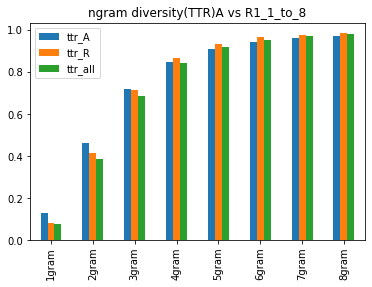

time: 229 ms (started: 2022-05-03 01:41:51 +02:00)


In [41]:
normed_diver = detailAR1_num.get_ttr( imgName = f'/diver(TTR)_ngram{n_start}_{max_n}_num.png' ) #show and store figure 
#normed_diver.rename(columns = {'len_A': 'normed_len_A', 'len_R': 'normed_len_R', 'len_all': 'normed_len_all'}, inplace=True)
normed_diver

In [42]:
#use method of class CorpusCompareReport:
display(detailAR1_num.get_coverage())
detailAR1_num.get_normed_freq()#le recouvrement

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R1,0.687218,0.437055,0.246093,0.130724,0.069503,0.037447,0.02065,0.011781


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs R1,0.212838,0.09384,0.04654,0.02363,0.012382,0.006649,0.003668,0.002096


time: 14.9 ms (started: 2022-05-03 01:41:51 +02:00)


In [43]:
freq_df = detailAR1_num.get_freq_report()#length of ngram_df
freq_df


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,4715,10745,9384,5881,3354,1871,1051,606


time: 6.72 ms (started: 2022-05-03 01:41:52 +02:00)


In [44]:
diver_df = detailAR1_num.get_len_all()
diver_df 

,len_A,len_R,len_all
1gram,6861,20007,22153
2gram,24585,100664,114504
3gram,38132,172887,201635
4gram,44988,209770,248877
5gram,48257,225985,270888
6gram,49964,233305,281398
7gram,50897,236659,286505
8gram,51439,238295,289128


time: 8.35 ms (started: 2022-05-03 01:41:52 +02:00)


##### The type/token ratio

### get common_text
>if the length of ngram with the max n is not 1, then this function depends on `get_common_text_singleN` (look at the last section of this notebook), so `with the same bug` so that the function may give some text that are not the ngram in common, so that we have to check that .

In [28]:
prefix = "A vs R1"

time: 431 µs (started: 2022-05-09 18:56:07 +02:00)


In [29]:
#too much short text in common, test the method `get_common_text` with longer ngram:
detail_AR1 = corpusCompareAR1.ngram_info( n_start = 14, max_n = 19, info = prefix,  store = True)

computing ngram in common with n in range [14,19]
done with 18.811204195022583s, analysing result for each n 
There are  13 14gram in both corpus. Coverage of A to R is 0.00024894199651481205
There are  7 15gram in both corpus. Coverage of A to R is 0.00013398924257795303
There are  3 16gram in both corpus. Coverage of A to R is 5.74052812858783e-05
There are  1 17gram in both corpus. Coverage of A to R is 1.9129237126023413e-05
There are  0 18gram in both corpus. Coverage of A to R is 0.0
There are  0 19gram in both corpus. Coverage of A to R is 0.0
done with 12.752392530441284s
writing results in res_report/A vs R1_14_to_19
time: 31.6 s (started: 2022-05-09 18:56:08 +02:00)


> READ THE NGRAM INFO FROM 14 TO 19 FROM FOLDER

In [30]:
#read the ngram info from 14 to 19 from folder 
res_folder1 = resFolder+f"/{prefix}_{14}_to_{19}"
print(res_folder1)
detail_AR1 = CorpusCompareReport.fromFolder(res_folder1)

res_report/A vs R1_14_to_19
time: 39.8 ms (started: 2022-05-09 18:56:39 +02:00)


In [31]:
#the text in common from 4gram to 8gram where 8 gram is the longest computed ngram in detailAR1
freq_df1 = detail_AR1.get_freq_report()
display(freq_df1) 

,14gram,15gram,16gram,17gram,18gram,19gram
length,13,7,3,1,0,0


time: 7.56 ms (started: 2022-05-09 18:56:39 +02:00)


In [32]:
# also defined in the previous session to test get_common_text_singleN
corpusR1_text = ' '.join(tokenizer_fr(corpusR1_txt))
corpusA_text = ' '.join(tokenizer_fr(corpusA_txt))

time: 5.77 s (started: 2022-05-09 18:56:39 +02:00)


In [33]:
res_commonAR1 = detail_AR1.get_common_text(min_n = 14, verbose = False, filename = "common_text_backward.txt") #store = True by default
print(len(res_commonAR1))
print(np.all([txt.lower() in corpusA_text.lower() for txt in res_commonAR1 ]))
res_commonAR1

7
True


['formation hypoéchogène hétérogène de contours irréguliers renfermant des zones kystiques et prenant fortement le doppler couleur',
 'une formation hypoéchogène hétérogène de contours irréguliers renfermant des zones kystiques et prenant fortement le doppler',
 "ans sans antécédents pathologiques particuliers qui présenté il 10 mois des métrorragies de moyenne abondance L'examen",
 "Le tout évoluant dans un contexte d'apyrexie et de conservation de l'état général L'examen clinique",
 'pour la prise en charge des douleurs abdominales survenant 15 jours après un accouchement par',
 'mobile par rapport au plan superficiel et fixe par rapport au plan profond avec',
 'était marquée par une amélioration clinique et radiologique sans récidive avec un recul de']

time: 14.1 ms (started: 2022-05-09 18:56:45 +02:00)


### Text distribution in the corpus 

In [34]:
distrA_common, distrA_common_f2s  = corpusA.get_distribution_common(res_commonAR1)
len(distrA_common), len(distrA_common_f2s)

(7, 4)

time: 391 ms (started: 2022-05-09 18:56:45 +02:00)


In [35]:
distrR1_common, distrR1_common_f2s  = corpusR1.get_distribution_common(res_commonAR1)
len(distrR1_common), len(distrR1_common_f2s)

(7, 6)

time: 1.64 s (started: 2022-05-09 18:56:46 +02:00)


In [36]:
#write result in csv file
#will be stored in res_folder1
detail_AR1.report_file_s2f('common_reportAR1_test.tsv', res_commonAR1, distrA_common, distrR1_common, 
                          name0 = 'corpusA', name1 = 'corpusR1')

time: 1.43 ms (started: 2022-05-09 18:56:47 +02:00)


In [37]:
#the int is the index of text in res_commonAR1
distrA_common_f2s

{'gen_temp0.6': [2, 3],
 'gen_temp0.5': [0, 1, 5],
 'gen_temp0.3': [6],
 'gen_temp0.9': [4]}

time: 6.32 ms (started: 2022-05-09 18:56:47 +02:00)


In [38]:
distrR1_common

{0: ['FR101445.json'],
 1: ['FR101445.json'],
 2: ['FR101174.json'],
 3: ['FR101391.json'],
 4: ['FR101104.json'],
 5: ['FR101298.json'],
 6: ['FR101540.json']}

time: 6.51 ms (started: 2022-05-09 18:56:47 +02:00)


In [39]:
#TACKE CARE ABOUT THE INPUT TYPE for distribution!!
detail_AR1.report_file_f2s('common_reportAR1_f2s_test.tsv', res_commonAR1, distrA_common_f2s, distrR1_common, 
                          name0 = 'corpusA', name1 = 'corpusR1')

time: 5.9 ms (started: 2022-05-09 18:56:47 +02:00)


In [40]:
#another format of f2s (file to text in common)
detail_AR1.report_file_f2s_new('common_reportAR1_f2s_new_test.tsv', res_commonAR1, distrA_common_f2s, distrR1_common, 
                          name0 = 'corpusA', name1 = 'corpusR1')


time: 5.92 ms (started: 2022-05-09 18:56:47 +02:00)


### Try with other pair of corpus

#### compare A and R2

In [41]:
corpusCompareAR2 = CorpusCompare(corpusA, corpusR2)
#compute the ngram in common, coverage and normed frequency
detailAR2 = corpusCompareAR2.ngram_info(n_start = 1, max_n = 8, info = 'A vs R2', store = True)

coverAR2 = detailAR2.get_coverage()
#detailAR2_df = detailAR2.get_detail()
freqAR2_normed = detailAR2.get_normed_freq()
print('coverage:')
display(coverAR2)
print('recouvrement')
freqAR2_normed

computing ngram in common with n in range [1,8]
done with 15.621925354003906s, analysing result for each n 
There are  4073 1gram in both corpus. Coverage of A to R is 0.5552828902522154
There are  7533 2gram in both corpus. Coverage of A to R is 0.2926459733499087
There are  5096 3gram in both corpus. Coverage of A to R is 0.1297583581595498
There are  2314 4gram in both corpus. Coverage of A to R is 0.05044141689373297
There are  914 5gram in both corpus. Coverage of A to R is 0.01868394693268464
There are  353 6gram in both corpus. Coverage of A to R is 0.0069967493855545865
There are  135 7gram in both corpus. Coverage of A to R is 0.0026337866047564237
There are  43 8gram in both corpus. Coverage of A to R is 0.000832446036201723
done with 9.652926683425903s
writing results in res_report/A vs R2_1_to_8
coverage:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R2,0.555283,0.292646,0.129758,0.050441,0.018684,0.006997,0.002634,0.000832


recouvrement


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs R2,0.180757,0.065708,0.026447,0.010118,0.003766,0.001422,0.000539,0.000171


time: 25.5 s (started: 2022-05-09 18:56:47 +02:00)


,ttr_A,ttr_R,ttr_all
1gram,0.138873,0.095580,0.088559
2gram,0.487362,0.478303,0.450577
3gram,0.743581,0.786192,0.757318
4gram,0.868598,0.918277,0.898870
5gram,0.926251,0.965514,0.953772
6gram,0.955295,0.982660,0.975593
7gram,0.970556,0.989356,0.984923
8gram,0.978111,0.992005,0.988952


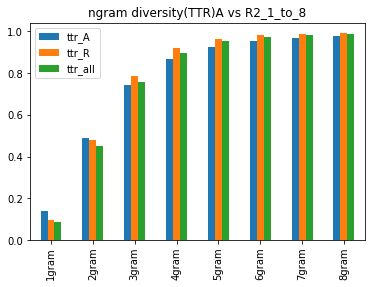

time: 304 ms (started: 2022-05-09 18:57:13 +02:00)


In [42]:
detailAR2.get_ttr(imgName = 'diver_ngram(TTR)AR2.png')

In [43]:
rarerepo_AR2 = detailAR2.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1676,4887,4124,2095,857,341,135,43


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,4073,7533,5096,2314,914,353,135,43


time: 20.8 ms (started: 2022-05-09 18:57:13 +02:00)


#### R1 vs R2

In [65]:
CorpusCompareR12 = CorpusCompare(corpusR1, corpusR2)
detail_R12 = CorpusCompareR12.ngram_info(n_start = 1, max_n = 8, info = 'R1_R2', store = True)

cover_R12 = detail_R12.get_coverage()
freq_R12_normed = detail_R12.get_normed_freq()

cover_freq_R12_df = pd.concat([cover_R12, freq_R12_normed]).T
cover_freq_R12_df

computing ngram in common with n in range [1,8]
done with 27.89149498939514s, analysing result for each n 
There are  9672 1gram in both corpus. Coverage of A to R is 0.4460431654676259
There are  23773 2gram in both corpus. Coverage of A to R is 0.22262907017034547
There are  17823 3gram in both corpus. Coverage of A to R is 0.09930354357031423
There are  8778 4gram in both corpus. Coverage of A to R is 0.04092364928180814
There are  3697 5gram in both corpus. Coverage of A to R is 0.01615391001524943
There are  1570 6gram in both corpus. Coverage of A to R is 0.006692128011457605
There are  713 7gram in both corpus. Coverage of A to R is 0.00300922604225578
There are  353 8gram in both corpus. Coverage of A to R is 0.0014836857612400755
done with 15.887422323226929s
writing results in res_report/R1_R2_1_to_8


,couverture_R1_R2,recouvrement_R1_R2
1gram,0.446043,0.309178
2gram,0.222629,0.132480
3gram,0.099304,0.055667
4gram,0.040924,0.022458
5gram,0.016154,0.008806
6gram,0.006692,0.003641
7gram,0.003009,0.001636
8gram,0.001484,0.000807


time: 44.2 s (started: 2022-05-03 01:44:03 +02:00)


,ttr_A,ttr_R,ttr_all
1gram,0.090180,0.095580,0.070764
2gram,0.444093,0.478303,0.405919
3gram,0.746431,0.786192,0.724248
4gram,0.892065,0.918277,0.884163
5gram,0.951807,0.965514,0.949695
6gram,0.975695,0.982660,0.975320
7gram,0.985406,0.989356,0.985595
8gram,0.989499,0.992005,0.989843


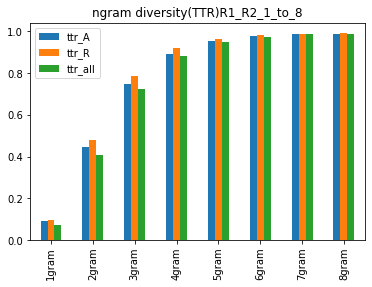

time: 237 ms (started: 2022-05-03 01:44:48 +02:00)


In [66]:
detail_R12.get_ttr(imgName = 'diver_ngram(TTR)_R12.png')

In [67]:
rarerepo_R12 = detail_R12.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,6229,19661,16259,8373,3597,1544,708,351


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,9672,23773,17823,8778,3697,1570,713,353


time: 24.2 ms (started: 2022-05-03 01:44:48 +02:00)


#### corpus A2
#####  A2 vs R1

In [23]:
corpusCompareA2R1 = CorpusCompare(corpusA2, corpusR1)
#compute the ngram in common, coverage and normed frequency
detailA2R1 = corpusCompareA2R1.ngram_info(n_start = 1, max_n = 8, info = 'A2 vs R1', store = True)

coverA2R1 = detailA2R1.get_coverage()
#detailAR2_df = detailAR2.get_detail()
freqA2R1_normed = detailA2R1.get_normed_freq()
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA2R1)
freqA2R1_normed

computing ngram in common with n in range [1,8]
done with 17.53905415534973s, analysing result for each n 
There are  3022 1gram in both corpus. Coverage of A to R is 0.4673677698731828
There are  5087 2gram in both corpus. Coverage of A to R is 0.3066305003013864
There are  3478 3gram in both corpus. Coverage of A to R is 0.15517779859902736
There are  1894 4gram in both corpus. Coverage of A to R is 0.07602761721258831
There are  1112 5gram in both corpus. Coverage of A to R is 0.04274621357730453
There are  727 6gram in both corpus. Coverage of A to R is 0.027355508729680914
There are  548 7gram in both corpus. Coverage of A to R is 0.02031360047447826
There are  443 8gram in both corpus. Coverage of A to R is 0.01621166654468272
done with 9.620291471481323s
writing results in res_report/A2 vs R1_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs R1,0.467368,0.306631,0.155178,0.076028,0.042746,0.027356,0.020314,0.016212


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs R1,0.120264,0.043006,0.017529,0.007974,0.004382,0.002791,0.002081,0.001673


time: 27.4 s (started: 2022-05-07 23:47:48 +02:00)


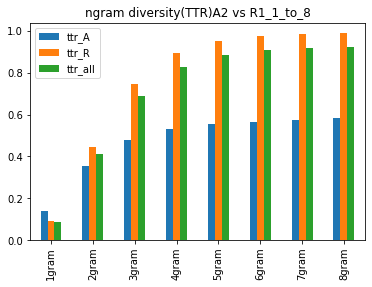

time: 269 ms (started: 2022-05-07 23:48:15 +02:00)


In [24]:
normed_diver_a2r1 = detailA2R1.get_ttr( imgName = f'/diver_ngram(TTR)A2R1.png' )

In [25]:
rarerepo_A2R1 = detailA2R1.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1016,3138,2757,1701,1066,718,548,443


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,3022,5087,3478,1894,1112,727,548,443


time: 20.7 ms (started: 2022-05-07 23:48:16 +02:00)


In [26]:
rarerepo_A2R1 = detailA2R1.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,312,1435,1557,1134,826,615,503,423


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,3022,5087,3478,1894,1112,727,548,443


time: 26.6 ms (started: 2022-05-07 23:48:16 +02:00)


##### A2 vs R2

computing ngram in common with n in range [1,8]
done with 13.701218366622925s, analysing result for each n 
There are  2542 1gram in both corpus. Coverage of A to R is 0.3931333127126508
There are  3474 2gram in both corpus. Coverage of A to R is 0.20940325497287524
There are  1862 3gram in both corpus. Coverage of A to R is 0.08307678579395886
There are  701 4gram in both corpus. Coverage of A to R is 0.028139049454078354
There are  268 5gram in both corpus. Coverage of A to R is 0.010302144998846775
There are  111 6gram in both corpus. Coverage of A to R is 0.004176700782661047
There are  48 7gram in both corpus. Coverage of A to R is 0.0017792934722170738
There are  24 8gram in both corpus. Coverage of A to R is 0.0008782844177706214
done with 8.400954723358154s
writing results in res_report/A2 vs R2_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs R2,0.393133,0.209403,0.083077,0.028139,0.010302,0.004177,0.001779,0.000878


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs R2,0.109593,0.031711,0.010399,0.003348,0.001216,0.000494,0.000212,0.000106


common text rare in R2
K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,870,2018,1406,595,241,105,47,24


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2542,3474,1862,701,268,111,48,24


type/token ratio in A2 vs R2


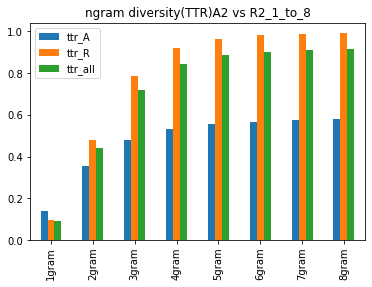

time: 22.5 s (started: 2022-05-07 23:48:16 +02:00)


In [27]:
corpusCompareA2R2 = CorpusCompare(corpusA2, corpusR2)
#compute the ngram in common, coverage and normed frequency
detailA2R2 = corpusCompareA2R2.ngram_info(n_start = 1, max_n = 8, info = 'A2 vs R2', store = True)

coverA2R2 = detailA2R2.get_coverage()
#detailAR2_df = detailAR2.get_detail()
freqA2R2_normed = detailA2R2.get_normed_freq() #recouvrement
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA2R2)
# print('\033[1mrecouvrement\033[0m')
display(freqA2R2_normed)

print("\033[1mcommon text rare in R2\033[0m" )
rarerepo_A2R2 = detailA2R2.get_rare_report(k = 5)

print('\033[1mtype/token ratio in A2 vs R2\033[0m')
normed_diver_a2r2 = detailA2R2.get_ttr( imgName = f'/diver_ngram(TTR)A2R2.png' )

In [33]:
#reload result from folder
detailA2R2 = CorpusCompareReport.fromFolder('res_report/A2 vs R2_1_to_8')

time: 61.9 ms (started: 2022-05-09 13:00:59 +02:00)


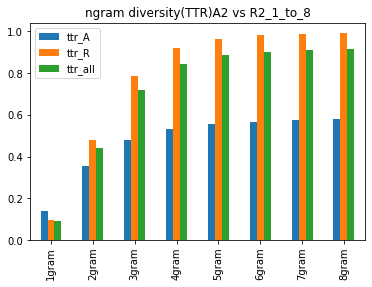

time: 218 ms (started: 2022-05-09 13:01:28 +02:00)


In [ ]:
normed_diver_a2r2 = detailA2R2.get_ttr( imgName = f'/diver_ngram(TTR)A2R2.png' )

In [35]:
rarerepo_A2R2_k5 = detailA2R2.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,870,2018,1406,595,241,105,47,24


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2542,3474,1862,701,268,111,48,24


time: 22 ms (started: 2022-05-09 13:02:22 +02:00)


In [36]:
rarerepo_A2R2_k1 = detailA2R2.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,264,858,704,333,173,81,40,21


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2542,3474,1862,701,268,111,48,24


time: 32.5 ms (started: 2022-05-09 13:02:22 +02:00)


##### A2 vs A

computing ngram in common with n in range [1,8]
done with 3.945543050765991s, analysing result for each n 
There are  1922 1gram in both corpus. Coverage of A to R is 0.2972471388802969
There are  2194 2gram in both corpus. Coverage of A to R is 0.13224834237492467
There are  1130 3gram in both corpus. Coverage of A to R is 0.05041716860750457
There are  451 4gram in both corpus. Coverage of A to R is 0.018103725112395632
There are  188 5gram in both corpus. Coverage of A to R is 0.007226877835011917
There are  81 6gram in both corpus. Coverage of A to R is 0.0030478627332931967
There are  32 7gram in both corpus. Coverage of A to R is 0.0011861956481447158
There are  14 8gram in both corpus. Coverage of A to R is 0.0005123325770328625
done with 2.9847640991210938s
writing results in res_report/A2 vs A_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs A,0.297247,0.132248,0.050417,0.018104,0.007227,0.003048,0.001186,0.000512


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs A,0.161798,0.054663,0.01866,0.006412,0.002515,0.001053,0.000409,0.000177


common text rare in A
K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1073,1526,914,399,171,76,31,14


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,1922,2194,1130,451,188,81,32,14


type/token ratio in A2 vs A


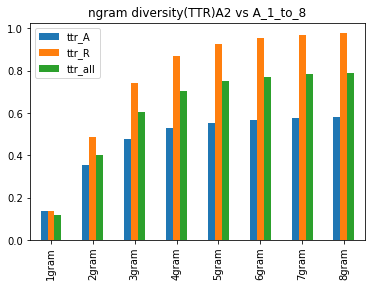

time: 7.33 s (started: 2022-05-07 23:48:38 +02:00)


In [28]:
corpusCompareA2A = CorpusCompare(corpusA2, corpusA)
#compute the ngram in common, coverage and normed frequency
detailA2A = corpusCompareA2A.ngram_info(n_start = 1, max_n = 8, info = 'A2 vs A', store = True)

coverA2A = detailA2A.get_coverage()

freqA2A_normed = detailA2A.get_normed_freq() #recouvrement
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA2A)
display(freqA2A_normed)

print("\033[1mcommon text rare in A\033[0m" )
rarerepo_A2A= detailA2A.get_rare_report(k = 5)

print('\033[1mtype/token ratio in A2 vs A\033[0m')
normed_diver_a2a = detailA2A.get_ttr( imgName = f'/diver_ngram(TTR)A2A.png' )

In [ ]:
detailA2R2 = CorpusCompareReport.fromFolder('res_report/A2 vs R2_1_to_8')

In [ ]:
normed_diver_a2r2 = detailA2R2.get_ttr( imgName = f'/diver_ngram(TTR)A2R2.png' )
rarerepo_A2R2_k5 = detailA2R2.get_rare_report(k = 5)
rarerepo_A2R2_k1 = detailA2R2.get_rare_report(k = 1)

##### A vs A2

computing ngram in common with n in range [1,8]
done with 3.8518307209014893s, analysing result for each n 
There are  1922 1gram in both corpus. Coverage of A to R is 0.26203135650988413
There are  2194 2gram in both corpus. Coverage of A to R is 0.08523367390544268
There are  1130 3gram in both corpus. Coverage of A to R is 0.028772948336006927
There are  451 4gram in both corpus. Coverage of A to R is 0.009831062670299727
There are  188 5gram in both corpus. Coverage of A to R is 0.003843087552893559
There are  81 6gram in both corpus. Coverage of A to R is 0.0016054864029176248
There are  32 7gram in both corpus. Coverage of A to R is 0.0006243049729793004
There are  14 8gram in both corpus. Coverage of A to R is 0.0002710289420191656
done with 2.8524134159088135s
writing results in res_report/A vs A2_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs A2,0.262031,0.085234,0.028773,0.009831,0.003843,0.001605,0.000624,0.000271


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs A2,0.161798,0.054663,0.01866,0.006412,0.002515,0.001053,0.000409,0.000177


common text rare in A
K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1202,1639,910,383,161,71,27,11


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,1922,2194,1130,451,188,81,32,14


type/token ratio in A2 vs A


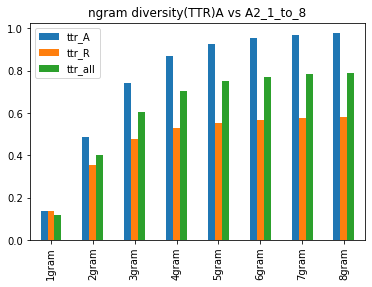

time: 7.07 s (started: 2022-05-09 13:04:53 +02:00)


In [37]:
corpusCompareAA2 = CorpusCompare(corpusA, corpusA2)
#compute the ngram in common, coverage and normed frequency
detailAA2 = corpusCompareAA2.ngram_info(n_start = 1, max_n = 8, info = 'A vs A2', store = True)

coverAA2 = detailAA2.get_coverage()

freqAA2_normed = detailAA2.get_normed_freq() #recouvrement
print('\033[1mcoverage & recouvrement \033[0m')
display(coverAA2)
display(freqAA2_normed)#same with AA2

print("\033[1mcommon text rare in A\033[0m" )
rarerepo_AA2= detailAA2.get_rare_report(k = 5) #same with AA2

print('\033[1mtype/token ratio in A2 vs A\033[0m')
normed_diver_aa2 = detailAA2.get_ttr( imgName = f'/diver_ngram(TTR)AA2.png' )

In [38]:
detailAA2 = CorpusCompareReport.fromFolder('res_report/A vs A2_1_to_8')

time: 41.4 ms (started: 2022-05-09 13:05:13 +02:00)


In [17]:
# normed_diver_aa2 = detailAA2.get_ttr( imgName = f'/diver_ngram(TTR)AA2.png' )

time: 37.8 ms (started: 2022-05-10 13:19:22 +02:00)


In [40]:
rarerepo_AA2_k5 = detailAA2.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1202,1639,910,383,161,71,27,11


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,1922,2194,1130,451,188,81,32,14


time: 24.7 ms (started: 2022-05-09 13:05:39 +02:00)


In [41]:
rarerepo_AA2_k1 = detailAA2.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,549,855,566,244,104,53,23,11


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,1922,2194,1130,451,188,81,32,14


time: 22.7 ms (started: 2022-05-09 13:05:53 +02:00)


#### Corpus A3
##### A3 vs R1

In [14]:
corpusCompareA3R1 = CorpusCompare(corpusA3, corpusR1)
#compute the ngram in common, coverage and normed frequency
detailA3R1 = corpusCompareA3R1.ngram_info(n_start = 1, max_n = 8, info = 'A3 vs R1', store = True)

coverA3R1 = detailA3R1.get_coverage()

freqA3R1_normed = detailA3R1.get_normed_freq()
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA3R1)
freqA3R1_normed

computing ngram in common with n in range [1,8]
done with 18.416158199310303s, analysing result for each n 
There are  4597 1gram in both corpus. Coverage of A to R is 0.5026240979663241
There are  9760 2gram in both corpus. Coverage of A to R is 0.3849946747662814
There are  7956 3gram in both corpus. Coverage of A to R is 0.22202377630183626
There are  5103 4gram in both corpus. Coverage of A to R is 0.12638070236267274
There are  3306 5gram in both corpus. Coverage of A to R is 0.077850515706683
There are  2294 6gram in both corpus. Coverage of A to R is 0.05265694938597498
There are  1680 7gram in both corpus. Coverage of A to R is 0.037907847827068006
There are  1305 8gram in both corpus. Coverage of A to R is 0.02908142799839551
done with 10.46987509727478s
writing results in res_report/A3 vs R1_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A3 vs R1,0.502624,0.384995,0.222024,0.126381,0.077851,0.052657,0.037908,0.029081


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A3 vs R1,0.175237,0.079756,0.038368,0.020431,0.012335,0.008315,0.006009,0.004636


time: 29.2 s (started: 2022-05-07 23:58:01 +02:00)


In [15]:
detailA3R1 = CorpusCompareReport.fromFolder('res_report/A3 vs R1_1_to_8')

time: 112 ms (started: 2022-05-07 23:59:15 +02:00)


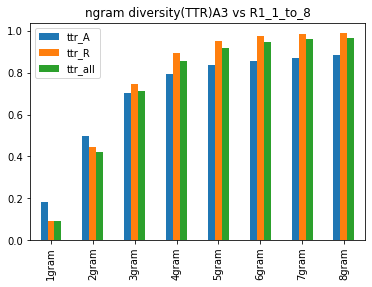

time: 221 ms (started: 2022-05-08 00:11:58 +02:00)


In [25]:
normed_diver_a3r1 = detailA3R1.get_ttr( imgName = f'/diver_ngram(TTR)A3R1.png' )

In [19]:
rarerepo_A3R1_k5 = detailA3R1.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1852,6650,6626,4675,3184,2258,1670,1301


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,4597,9760,7956,5103,3306,2294,1680,1305


time: 20.9 ms (started: 2022-05-08 00:00:49 +02:00)


In [20]:
rarerepo_A3R1_k1 = detailA3R1.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,624,3185,3909,3264,2527,1941,1505,1204


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,4597,9760,7956,5103,3306,2294,1680,1305


time: 19.9 ms (started: 2022-05-08 00:00:53 +02:00)


##### A3 vs R2

In [21]:
corpusCompareA3R2 = CorpusCompare(corpusA3, corpusR2)
#compute the ngram in common, coverage and normed frequency
detailA3R2 = corpusCompareA3R2.ngram_info(n_start = 1, max_n = 8, info = 'A3 vs R2', store = True)

coverA3R2 = detailA3R2.get_coverage()

freqA3R2_normed = detailA3R2.get_normed_freq()
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA3R2)
freqA3R2_normed

computing ngram in common with n in range [1,8]
done with 14.012664556503296s, analysing result for each n 
There are  3652 1gram in both corpus. Coverage of A to R is 0.39930024054231356
There are  6010 2gram in both corpus. Coverage of A to R is 0.2370715159165319
There are  3612 3gram in both corpus. Coverage of A to R is 0.10079812468605236
There are  1517 4gram in both corpus. Coverage of A to R is 0.037569963841695975
There are  553 5gram in both corpus. Coverage of A to R is 0.013022182451843828
There are  223 6gram in both corpus. Coverage of A to R is 0.005118788017904281
There are  89 7gram in both corpus. Coverage of A to R is 0.0020082133670291983
There are  36 8gram in both corpus. Coverage of A to R is 0.0008022462896109105
done with 8.657493352890015s
writing results in res_report/A3 vs R2_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A3 vs R2,0.3993,0.237072,0.100798,0.03757,0.013022,0.005119,0.002008,0.000802


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A3 vs R2,0.147466,0.05191,0.018937,0.006772,0.002337,0.000924,0.000365,0.000147


time: 22.8 s (started: 2022-05-08 00:10:53 +02:00)


In [23]:
detailA3R2 = CorpusCompareReport.fromFolder('res_report/A3 vs R2_1_to_8')

time: 72.7 ms (started: 2022-05-08 00:11:22 +02:00)


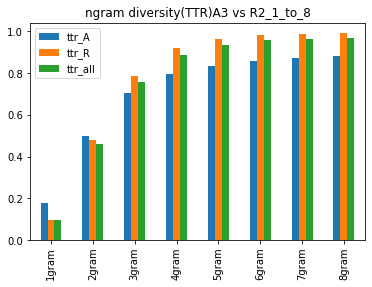

time: 223 ms (started: 2022-05-08 00:11:39 +02:00)


In [24]:
normed_diver_a3r2 = detailA3R2.get_ttr( imgName = f'/diver_ngram(TTR)A3R2.png' )

In [26]:
rarerepo_A3R2_k5 = detailA3R2.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1466,3816,2861,1334,506,210,88,36


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,3652,6010,3612,1517,553,223,89,36


time: 23.9 ms (started: 2022-05-08 00:14:41 +02:00)


In [27]:
rarerepo_A3R2_k1 = detailA3R2.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,470,1641,1443,759,334,154,69,31


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,3652,6010,3612,1517,553,223,89,36


time: 23 ms (started: 2022-05-08 00:14:53 +02:00)


##### A3 vs A

In [28]:
corpusCompareA3A = CorpusCompare(corpusA3, corpusA)
#compute the ngram in common, coverage and normed frequency
detailA3A = corpusCompareA3A.ngram_info(n_start = 1, max_n = 8, info = 'A3 vs A', store = True)

coverA3A = detailA3A.get_coverage()

freqA3A_normed = detailA3A.get_normed_freq()
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA3A)
freqA3A_normed

computing ngram in common with n in range [1,8]
done with 4.522944927215576s, analysing result for each n 
There are  2645 1gram in both corpus. Coverage of A to R is 0.2891974633719659
There are  3691 2gram in both corpus. Coverage of A to R is 0.1455958344838468
There are  2279 3gram in both corpus. Coverage of A to R is 0.0635988167661997
There are  1038 4gram in both corpus. Coverage of A to R is 0.025707068205458417
There are  467 5gram in both corpus. Coverage of A to R is 0.01099703292045401
There are  209 6gram in both corpus. Coverage of A to R is 0.004797429128887869
There are  87 7gram in both corpus. Coverage of A to R is 0.001963084976758879
There are  32 8gram in both corpus. Coverage of A to R is 0.000713107812987476
done with 3.666553258895874s
writing results in res_report/A3 vs A_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A3 vs A,0.289197,0.145596,0.063599,0.025707,0.010997,0.004797,0.001963,0.000713


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A3 vs A,0.191168,0.077868,0.031293,0.012181,0.005136,0.002228,0.000911,0.000332


time: 8.33 s (started: 2022-05-08 00:15:33 +02:00)


In [29]:
detailA3A = CorpusCompareReport.fromFolder('res_report/A3 vs A_1_to_8')

time: 54.7 ms (started: 2022-05-08 00:15:58 +02:00)


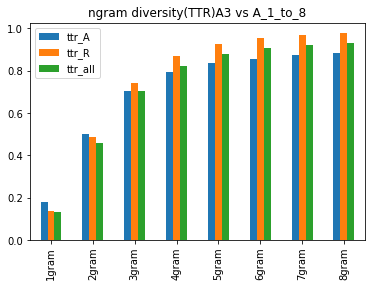

time: 215 ms (started: 2022-05-08 00:16:04 +02:00)


In [30]:
normed_diver_a3a = detailA3A.get_ttr( imgName = f'/diver_ngram(TTR)A3A.png' )

In [31]:
rarerepo_A3A_k5 = detailA3A.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1609,2771,1930,925,429,199,86,32


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2645,3691,2279,1038,467,209,87,32


time: 23 ms (started: 2022-05-08 00:16:48 +02:00)


In [32]:
rarerepo_A3A_k1 = detailA3A.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,648,1392,1102,574,283,131,59,24


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2645,3691,2279,1038,467,209,87,32


time: 24 ms (started: 2022-05-08 00:16:48 +02:00)


##### A3 vs A2

In [33]:
corpusCompareA3A2 = CorpusCompare(corpusA3, corpusA2)
#compute the ngram in common, coverage and normed frequency
detailA3A2 = corpusCompareA3A2.ngram_info(n_start = 1, max_n = 8, info = 'A3 vs A2', store = True)

coverA3A2 = detailA3A2.get_coverage()

freqA3A2_normed = detailA3A2.get_normed_freq()
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA3A2)
freqA3A2_normed

computing ngram in common with n in range [1,8]
done with 3.6209535598754883s, analysing result for each n 
There are  2745 1gram in both corpus. Coverage of A to R is 0.3001312048983162
There are  4016 2gram in both corpus. Coverage of A to R is 0.15841584158415842
There are  2798 3gram in both corpus. Coverage of A to R is 0.07808226823687
There are  1620 4gram in both corpus. Coverage of A to R is 0.04012085789291198
There are  1040 5gram in both corpus. Coverage of A to R is 0.024490180379597794
There are  791 6gram in both corpus. Coverage of A to R is 0.018156777229427292
There are  673 7gram in both corpus. Coverage of A to R is 0.015185703325962363
There are  615 8gram in both corpus. Coverage of A to R is 0.013705040780853056
done with 2.833524703979492s
writing results in res_report/A3 vs A2_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A3 vs A2,0.300131,0.158416,0.078082,0.040121,0.02449,0.018157,0.015186,0.013705


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A3 vs A2,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.00953,0.008591


time: 6.59 s (started: 2022-05-08 00:18:13 +02:00)


In [34]:
detailA3A2 = CorpusCompareReport.fromFolder('res_report/A3 vs A2_1_to_8')

time: 57.8 ms (started: 2022-05-08 00:18:22 +02:00)


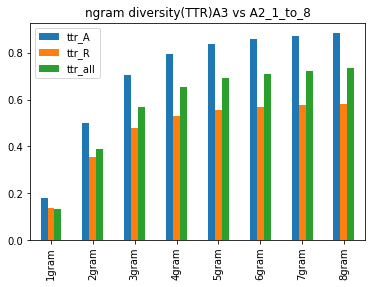

time: 221 ms (started: 2022-05-08 00:21:54 +02:00)


In [41]:
normed_diver_a3a2 = detailA3A2.get_ttr( imgName = f'/diver_ngram(TTR)A3A2.png' )

In [36]:
rarerepo_A3A2_k5 = detailA3A2.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1867,3140,2236,1205,692,465,361,317


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2745,4016,2798,1620,1040,791,673,615


time: 24.4 ms (started: 2022-05-08 00:19:15 +02:00)


In [37]:
rarerepo_A3A2_k5 = detailA3A2.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,901,1729,1359,724,384,239,172,150


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2745,4016,2798,1620,1040,791,673,615


time: 23.2 ms (started: 2022-05-08 00:19:17 +02:00)


##### A2 vs A3

In [38]:
corpusCompareA2A3 = CorpusCompare(corpusA2, corpusA3)
#compute the ngram in common, coverage and normed frequency
detailA2A3 = corpusCompareA2A3.ngram_info(n_start = 1, max_n = 8, info = 'A2 vs A3', store = True)

coverA2A3 = detailA2A3.get_coverage()

freqA2A3_normed = detailA2A3.get_normed_freq()
print('\033[1mcoverage & recouvrement \033[0m')
display(coverA2A3)
freqA2A3_normed

computing ngram in common with n in range [1,8]
done with 3.734715700149536s, analysing result for each n 
There are  2745 1gram in both corpus. Coverage of A to R is 0.42452830188679247
There are  4016 2gram in both corpus. Coverage of A to R is 0.24207353827606992
There are  2798 3gram in both corpus. Coverage of A to R is 0.12483826350778567
There are  1620 4gram in both corpus. Coverage of A to R is 0.06502890173410404
There are  1040 5gram in both corpus. Coverage of A to R is 0.039978473129853156
There are  791 6gram in both corpus. Coverage of A to R is 0.02976369656833233
There are  673 7gram in both corpus. Coverage of A to R is 0.024947177225043554
There are  615 8gram in both corpus. Coverage of A to R is 0.022506038205372173
done with 2.8891494274139404s
writing results in res_report/A2 vs A3_1_to_8
coverage & recouvrement 


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs A3,0.424528,0.242074,0.124838,0.065029,0.039978,0.029764,0.024947,0.022506


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs A3,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.00953,0.008591


time: 6.76 s (started: 2022-05-08 00:21:17 +02:00)


In [39]:
detailA2A3 = CorpusCompareReport.fromFolder('res_report/A2 vs A3_1_to_8')

time: 76.1 ms (started: 2022-05-08 00:21:30 +02:00)


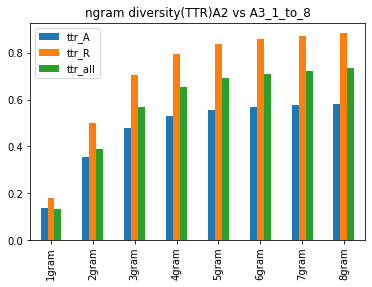

time: 212 ms (started: 2022-05-08 00:21:44 +02:00)


In [40]:
normed_diver_a2a3 = detailA2A3.get_ttr( imgName = f'/diver_ngram(TTR)A2A3.png' )

In [42]:
rarerepo_A2A3_k5 = detailA2A3.get_rare_report(k = 5)

K = 5
total nomber of rare ngram set (frequency <= 5) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k5,1727,3033,2312,1325,814,593,493,451


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2745,4016,2798,1620,1040,791,673,615


time: 23 ms (started: 2022-05-08 00:22:11 +02:00)


In [43]:
rarerepo_A2A3_k1 = detailA2A3.get_rare_report(k = 1)

K = 1
total nomber of rare ngram set (frequency <= 1) for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_k1,744,1490,1330,789,477,326,265,249


total nomber of ngram set for each n:


,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
length,2745,4016,2798,1620,1040,791,673,615


time: 20.3 ms (started: 2022-05-08 00:22:25 +02:00)


### CorpusCompareList

In [14]:
res_folder = resFolder+f"/A vs R1_1_to_8"
detailAR1 = CorpusCompareReport.fromFolder(res_folder)
detailAR2 = CorpusCompareReport.fromFolder('res_report/A vs R2_1_to_8')
detail_R12 = CorpusCompareReport.fromFolder('res_report/R1_R2_1_to_8')

detailA2R1 = CorpusCompareReport.fromFolder('res_report/A2 vs R1_1_to_8')
detailA2R2 = CorpusCompareReport.fromFolder('res_report/A2 vs R2_1_to_8')
detailA2A = CorpusCompareReport.fromFolder('res_report/A2 vs A_1_to_8')

detailA3R1 = CorpusCompareReport.fromFolder('res_report/A3 vs R1_1_to_8')
detailA3R2 = CorpusCompareReport.fromFolder('res_report/A3 vs R2_1_to_8')
detailA3A = CorpusCompareReport.fromFolder('res_report/A3 vs A_1_to_8')

detailAA2 = CorpusCompareReport.fromFolder('res_report/A vs A2_1_to_8')
detailA3A2 = CorpusCompareReport.fromFolder('res_report/A3 vs A2_1_to_8')
detailA2A3 = CorpusCompareReport.fromFolder('res_report/A2 vs A3_1_to_8')

time: 770 ms (started: 2022-05-10 19:35:39 +02:00)


In [15]:
detail_R12.get_detail()['8gram'].head()

,8gram,freq_c0,freq_c1,percent_c0,percent_c1,percent_common_c0
0,dans un contexte de conservation de l'état général,10,1,0.000042,0.000005,0.023095
1,évoluant dans un contexte d'altération de l'état général,7,1,0.000029,0.000005,0.016166
2,Les suites opératoires étaient simples et la patiente,5,2,0.000021,0.000010,0.011547
3,conscient stable sur le plan hémodynamique et respiratoire,5,1,0.000021,0.000005,0.011547
4,Les suites opératoires étaient simples et le patient,4,1,0.000017,0.000005,0.009238


time: 26.8 ms (started: 2022-05-10 19:35:40 +02:00)


In [16]:
#the number of char 
print('nbr of char in R1:', len(corpusR1_txt))
print('nbr of char in R2:', len(corpusR2_txt))
print('nbr of char in A2:', len(corpusA2_txt))
print('nbr of char in A :', len(corpusA_txt))
print('nbr of char in A3:', len(corpusA3_txt))

nbr of char in R1: 1703732
nbr of char in R2: 1428893
nbr of char in A2: 378720
nbr of char in A : 381276
nbr of char in A3: 396144
time: 1.71 ms (started: 2022-05-10 19:35:40 +02:00)


#### make compare report list
##### 1. AR1, AR2, R1R2

In [17]:
names = ['AR1', 'AR2','R1R2', 'A2R1', 'A2R2']

compareRep_list = CorpusCompareList([detailAR1, detailAR2], names[:2] )
compareRep_list.get_klist()

[-1, 6]

time: 7.23 ms (started: 2022-05-10 19:35:41 +02:00)


In [18]:
compareRep_list.add( detail_R12, names[2] )
klist = compareRep_list.get_klist()
klist

[-1, 6, -1]

time: 3.66 ms (started: 2022-05-10 19:35:45 +02:00)


,AR1,AR2,R1R2
1gram,0.079985,0.074380,0.199118
2gram,0.057962,0.042628,0.109565
3gram,0.035132,0.021402,0.050783
4gram,0.019208,0.009160,0.021422
5gram,0.010013,0.003532,0.008568
6gram,0.005071,0.001374,0.003581
7gram,0.002529,0.000539,0.001625
8gram,0.001234,0.000171,0.000802


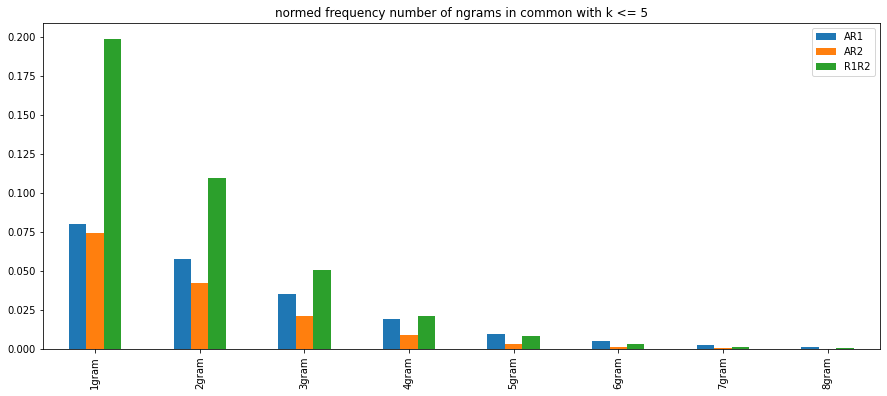

time: 328 ms (started: 2022-05-10 19:35:47 +02:00)


In [19]:
compareRep_list.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_AR12') #store = True by default

,AR1,AR2,R1R2
1gram,0.127028,0.106377,0.110060
2gram,0.032053,0.023080,0.022915
3gram,0.008632,0.005044,0.004885
4gram,0.002307,0.000958,0.001036
5gram,0.000677,0.000235,0.000238
6gram,0.000212,0.000048,0.000060
7gram,0.000070,0.000000,0.000011
8gram,0.000035,0.000000,0.000005


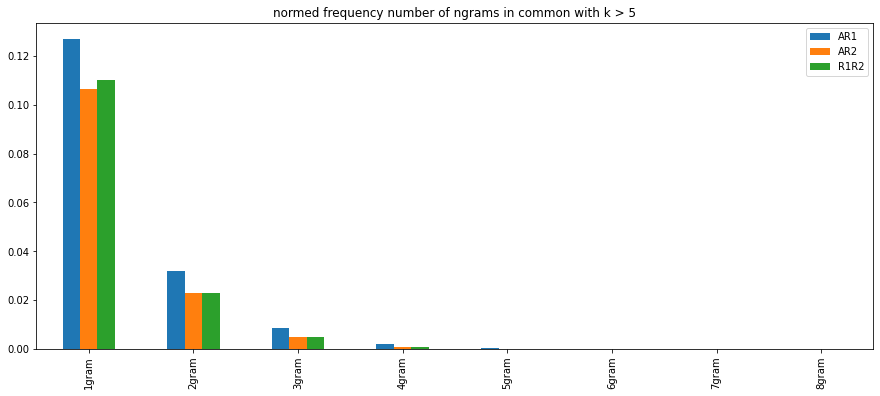

time: 284 ms (started: 2022-05-10 19:36:08 +02:00)


In [20]:
compareRep_list.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_AR12') #store = True by default

##### 2. add A2R1, A2R2


In [21]:
for name, cp in zip(names[3:], [detailA2R1, detailA2R2]):
    compareRep_list.add( cp, name )
klist = compareRep_list.get_klist()
klist

[-1, 6, -1, 6, 8]

time: 14.7 ms (started: 2022-05-10 19:36:11 +02:00)


In [22]:
cover_all = compareRep_list.get_cover_all(filename = 'coverage_all.tsv', store = True) #store = True by default, will be stored in resFolder

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R1,0.678528,0.425158,0.233545,0.119542,0.060058,0.029692,0.014574,0.007105
couverture_A vs R2,0.555283,0.292646,0.129758,0.050441,0.018684,0.006997,0.002634,0.000832
couverture_R1_R2,0.446043,0.222629,0.099304,0.040924,0.016154,0.006692,0.003009,0.001484
couverture_A2 vs R1,0.467368,0.306631,0.155178,0.076028,0.042746,0.027356,0.020314,0.016212
couverture_A2 vs R2,0.393133,0.209403,0.083077,0.028139,0.010302,0.004177,0.001779,0.000878


time: 79.4 ms (started: 2022-05-10 19:36:12 +02:00)


In [23]:
recouvrement = compareRep_list.get_recouvrement(filename = 'recouvrement.tsv', store = True)
recouvrement #un tab par k / evenement rare/(total de rare 1 a 8)+frequence/total pour chaque n 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs R1,0.207013,0.090015,0.043764,0.021515,0.010690,0.005283,0.002599,0.001269
recouvrement_A vs R2,0.180757,0.065708,0.026447,0.010118,0.003766,0.001422,0.000539,0.000171
recouvrement_R1_R2,0.309178,0.132480,0.055667,0.022458,0.008806,0.003641,0.001636,0.000807
recouvrement_A2 vs R1,0.120264,0.043006,0.017529,0.007974,0.004382,0.002791,0.002081,0.001673
recouvrement_A2 vs R2,0.109593,0.031711,0.010399,0.003348,0.001216,0.000494,0.000212,0.000106


time: 17.2 ms (started: 2022-05-10 19:36:16 +02:00)


In [24]:
display(detailA2A.get_len_all()[['len_all']].T)
# display(detailAA2.get_len_all()[['len_all']].T) #same as A2A

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_all,11879,40137,60556,70336,74745,76947,78202,78967


time: 12.8 ms (started: 2022-05-10 19:36:16 +02:00)


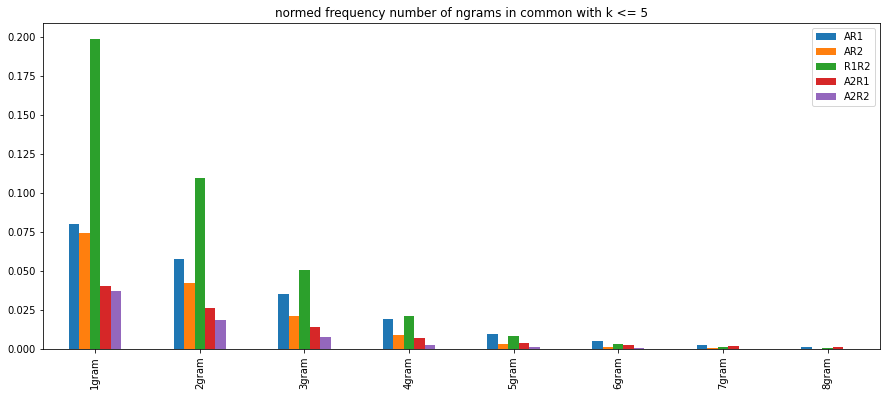

time: 345 ms (started: 2022-05-10 19:36:18 +02:00)


In [25]:
len_common_k5 = compareRep_list.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_AR12A2') #store = True by default

<AxesSubplot:title={'center':'normed frequency number of ngrams in common with k <=5'}>

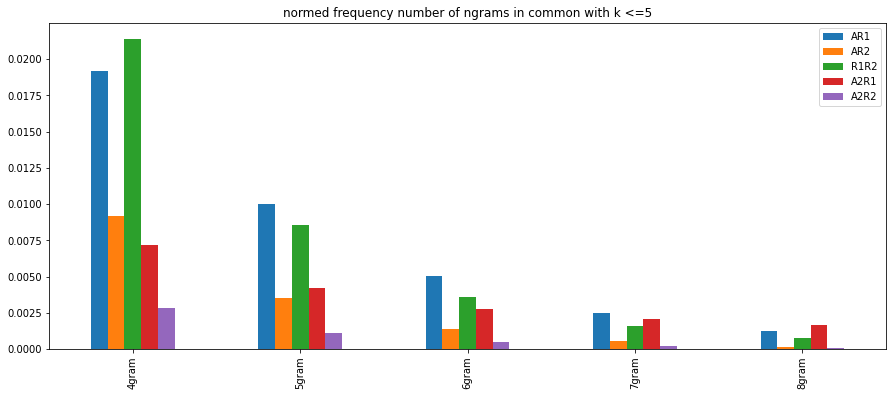

time: 179 ms (started: 2022-05-10 19:36:18 +02:00)


In [26]:
len_common_k5.tail(5).plot(kind = 'bar',figsize= (15,6), title = f"normed frequency number of ngrams in common with k <=5")

,AR1,AR2,R1R2,A2R1,A2R2
1gram,0.127028,0.106377,0.110060,0.079831,0.072085
2gram,0.032053,0.023080,0.022915,0.016477,0.013290
3gram,0.008632,0.005044,0.004885,0.003634,0.002547
4gram,0.002307,0.000958,0.001036,0.000813,0.000506
5gram,0.000677,0.000235,0.000238,0.000181,0.000122
6gram,0.000212,0.000048,0.000060,0.000035,0.000027
7gram,0.000070,0.000000,0.000011,0.000000,0.000004
8gram,0.000035,0.000000,0.000005,0.000000,0.000000


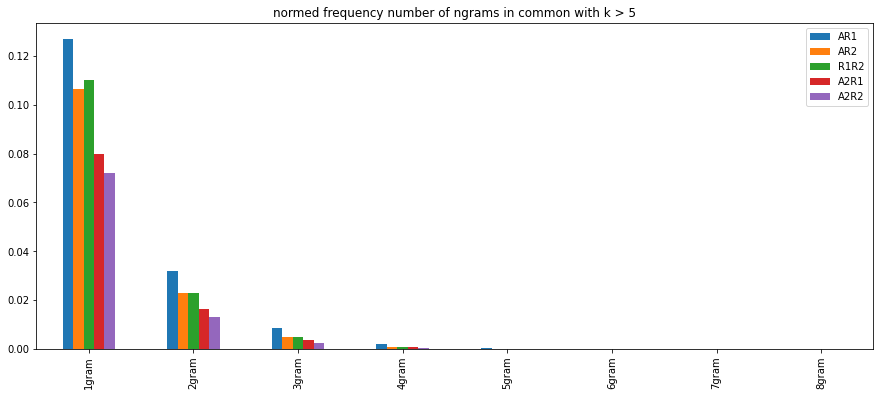

time: 341 ms (started: 2022-05-10 19:36:18 +02:00)


In [27]:
compareRep_list.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_AA2_R12') #store = True by default

##### 3.add A3R1, A3R2

In [28]:
for name, cp in zip(['A3R1', 'A3R2'], [detailA3R1, detailA3R2]):
    compareRep_list.add( cp, name )
klist = compareRep_list.get_klist()
klist

[-1, 6, -1, 6, 8, -1, 8]

time: 11 ms (started: 2022-05-10 19:36:19 +02:00)


In [29]:
cover_all = compareRep_list.get_cover_all(filename = 'coverage_all.tsv', store = True) #store = True by default, will be stored in resFolder

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R1,0.678528,0.425158,0.233545,0.119542,0.060058,0.029692,0.014574,0.007105
couverture_A vs R2,0.555283,0.292646,0.129758,0.050441,0.018684,0.006997,0.002634,0.000832
couverture_R1_R2,0.446043,0.222629,0.099304,0.040924,0.016154,0.006692,0.003009,0.001484
couverture_A2 vs R1,0.467368,0.306631,0.155178,0.076028,0.042746,0.027356,0.020314,0.016212
couverture_A2 vs R2,0.393133,0.209403,0.083077,0.028139,0.010302,0.004177,0.001779,0.000878
couverture_A3 vs R1,0.502624,0.384995,0.222024,0.126381,0.077851,0.052657,0.037908,0.029081
couverture_A3 vs R2,0.399300,0.237072,0.100798,0.037570,0.013022,0.005119,0.002008,0.000802


time: 34.8 ms (started: 2022-05-10 19:36:19 +02:00)


In [30]:
recouvrement = compareRep_list.get_recouvrement(filename = 'recouvrement.tsv', store = True)
recouvrement #un tab par k / evenement rare/(total de rare 1 a 8)+frequence/total pour chaque n 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs R1,0.207013,0.090015,0.043764,0.021515,0.010690,0.005283,0.002599,0.001269
recouvrement_A vs R2,0.180757,0.065708,0.026447,0.010118,0.003766,0.001422,0.000539,0.000171
recouvrement_R1_R2,0.309178,0.132480,0.055667,0.022458,0.008806,0.003641,0.001636,0.000807
recouvrement_A2 vs R1,0.120264,0.043006,0.017529,0.007974,0.004382,0.002791,0.002081,0.001673
recouvrement_A2 vs R2,0.109593,0.031711,0.010399,0.003348,0.001216,0.000494,0.000212,0.000106
recouvrement_A3 vs R1,0.175237,0.079756,0.038368,0.020431,0.012335,0.008315,0.006009,0.004636
recouvrement_A3 vs R2,0.147466,0.051910,0.018937,0.006772,0.002337,0.000924,0.000365,0.000147


time: 18.3 ms (started: 2022-05-10 19:36:19 +02:00)


,AR1,AR2,R1R2,A2R1,A2R2,A3R1,A3R2
1gram,0.079985,0.074380,0.199118,0.040433,0.037508,0.070598,0.059196
2gram,0.057962,0.042628,0.109565,0.026529,0.018420,0.054342,0.032960
3gram,0.035132,0.021402,0.050783,0.013895,0.007852,0.031954,0.015000
4gram,0.019208,0.009160,0.021422,0.007162,0.002842,0.018717,0.005955
5gram,0.010013,0.003532,0.008568,0.004201,0.001093,0.011880,0.002139
6gram,0.005071,0.001374,0.003581,0.002757,0.000468,0.008185,0.000870
7gram,0.002529,0.000539,0.001625,0.002081,0.000208,0.005973,0.000361
8gram,0.001234,0.000171,0.000802,0.001673,0.000106,0.004622,0.000147


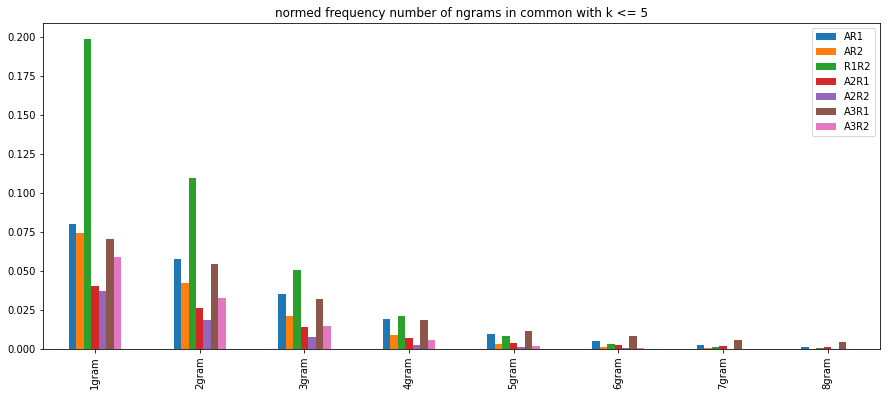

time: 513 ms (started: 2022-05-10 19:36:19 +02:00)


In [31]:
compareRep_list.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_AR12A2A3') #store = True by default

,AR1,AR2,R1R2,A2R1,A2R2,A3R1,A3R2
1gram,0.127028,0.106377,0.110060,0.079831,0.072085,0.104639,0.088270
2gram,0.032053,0.023080,0.022915,0.016477,0.013290,0.025414,0.018950
3gram,0.008632,0.005044,0.004885,0.003634,0.002547,0.006414,0.003937
4gram,0.002307,0.000958,0.001036,0.000813,0.000506,0.001714,0.000817
5gram,0.000677,0.000235,0.000238,0.000181,0.000122,0.000455,0.000199
6gram,0.000212,0.000048,0.000060,0.000035,0.000027,0.000130,0.000054
7gram,0.000070,0.000000,0.000011,0.000000,0.000004,0.000036,0.000004
8gram,0.000035,0.000000,0.000005,0.000000,0.000000,0.000014,0.000000


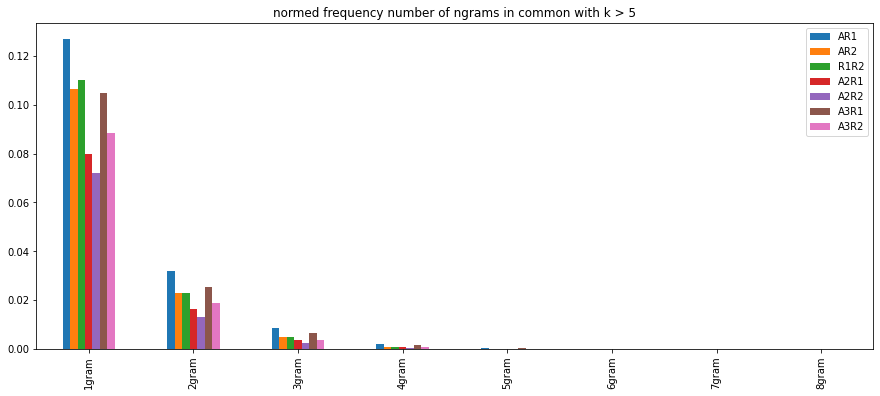

time: 366 ms (started: 2022-05-10 19:36:20 +02:00)


In [32]:
compareRep_list.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_AR12A2A3') #store = True by default

##### 4. add others

In [33]:
for name, cp in zip(['A2A','AA2','A2A3','A3A2'], [detailA2A, detailAA2, detailA2A3, detailA3A2]):
    compareRep_list.add( cp, name )
klist = compareRep_list.get_klist()
klist

[-1, 6, -1, 6, 8, -1, 8, 7, -1, -1, -1]

time: 5.16 ms (started: 2022-05-10 19:36:20 +02:00)


In [34]:
cover_all = compareRep_list.get_cover_all(filename = 'coverage_all.tsv', store = True) #store = True by default, will be stored in resFolder

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A vs R1,0.678528,0.425158,0.233545,0.119542,0.060058,0.029692,0.014574,0.007105
couverture_A vs R2,0.555283,0.292646,0.129758,0.050441,0.018684,0.006997,0.002634,0.000832
couverture_R1_R2,0.446043,0.222629,0.099304,0.040924,0.016154,0.006692,0.003009,0.001484
couverture_A2 vs R1,0.467368,0.306631,0.155178,0.076028,0.042746,0.027356,0.020314,0.016212
couverture_A2 vs R2,0.393133,0.209403,0.083077,0.028139,0.010302,0.004177,0.001779,0.000878
couverture_A3 vs R1,0.502624,0.384995,0.222024,0.126381,0.077851,0.052657,0.037908,0.029081
couverture_A3 vs R2,0.399300,0.237072,0.100798,0.037570,0.013022,0.005119,0.002008,0.000802
couverture_A2 vs A,0.297247,0.132248,0.050417,0.018104,0.007227,0.003048,0.001186,0.000512
couverture_A vs A2,0.262031,0.085234,0.028773,0.009831,0.003843,0.001605,0.000624,0.000271
couverture_A2 vs A3,0.424528,0.242074,0.124838,0.065029,0.039978,0.029764,0.024947,0.022506


time: 27.2 ms (started: 2022-05-10 19:36:21 +02:00)


In [35]:
recouvrement = compareRep_list.get_recouvrement(filename = 'recouvrement.tsv', store = True)
recouvrement #un tab par k / evenement rare/(total de rare 1 a 8)+frequence/total pour chaque n 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A vs R1,0.207013,0.090015,0.043764,0.021515,0.010690,0.005283,0.002599,0.001269
recouvrement_A vs R2,0.180757,0.065708,0.026447,0.010118,0.003766,0.001422,0.000539,0.000171
recouvrement_R1_R2,0.309178,0.132480,0.055667,0.022458,0.008806,0.003641,0.001636,0.000807
recouvrement_A2 vs R1,0.120264,0.043006,0.017529,0.007974,0.004382,0.002791,0.002081,0.001673
recouvrement_A2 vs R2,0.109593,0.031711,0.010399,0.003348,0.001216,0.000494,0.000212,0.000106
recouvrement_A3 vs R1,0.175237,0.079756,0.038368,0.020431,0.012335,0.008315,0.006009,0.004636
recouvrement_A3 vs R2,0.147466,0.051910,0.018937,0.006772,0.002337,0.000924,0.000365,0.000147
recouvrement_A2 vs A,0.161798,0.054663,0.018660,0.006412,0.002515,0.001053,0.000409,0.000177
recouvrement_A vs A2,0.161798,0.054663,0.018660,0.006412,0.002515,0.001053,0.000409,0.000177
recouvrement_A2 vs A3,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.009530,0.008591


time: 29.8 ms (started: 2022-05-10 19:36:21 +02:00)


,AR1,AR2,R1R2,A2R1,A2R2,A3R1,A3R2,A2A,AA2,A2A3,A3A2
1gram,0.079985,0.074380,0.199118,0.040433,0.037508,0.070598,0.059196,0.090327,0.101187,0.134219,0.145100
2gram,0.057962,0.042628,0.109565,0.026529,0.018420,0.054342,0.032960,0.038020,0.040835,0.079974,0.082795
3gram,0.035132,0.021402,0.050783,0.013895,0.007852,0.031954,0.015000,0.015093,0.015027,0.041696,0.040325
4gram,0.019208,0.009160,0.021422,0.007162,0.002842,0.018717,0.005955,0.005673,0.005445,0.020810,0.018926
5gram,0.010013,0.003532,0.008568,0.004201,0.001093,0.011880,0.002139,0.002288,0.002154,0.012070,0.010261
6gram,0.005071,0.001374,0.003581,0.002757,0.000468,0.008185,0.000870,0.000988,0.000923,0.008551,0.006705
7gram,0.002529,0.000539,0.001625,0.002081,0.000208,0.005973,0.000361,0.000396,0.000345,0.006981,0.005112
8gram,0.001234,0.000171,0.000802,0.001673,0.000106,0.004622,0.000147,0.000177,0.000139,0.006300,0.004428


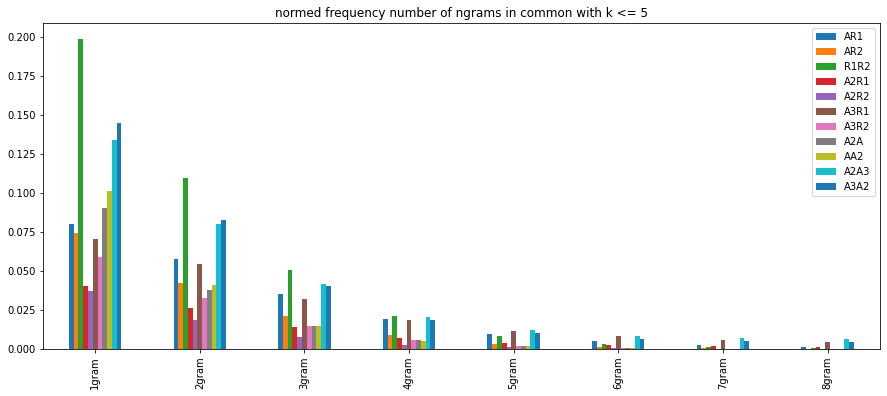

time: 524 ms (started: 2022-05-10 19:36:23 +02:00)


In [36]:
compareRep_list.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_all') #store = True by default

,AR1,AR2,R1R2,A2R1,A2R2,A3R1,A3R2,A2A,AA2,A2A3,A3A2
1gram,0.127028,0.106377,0.110060,0.079831,0.072085,0.104639,0.088270,0.071471,0.060611,0.079117,0.068237
2gram,0.032053,0.023080,0.022915,0.016477,0.013290,0.025414,0.018950,0.016643,0.013828,0.025920,0.023098
3gram,0.008632,0.005044,0.004885,0.003634,0.002547,0.006414,0.003937,0.003567,0.003633,0.008765,0.010135
4gram,0.002307,0.000958,0.001036,0.000813,0.000506,0.001714,0.000817,0.000739,0.000967,0.004633,0.006518
5gram,0.000677,0.000235,0.000238,0.000181,0.000122,0.000455,0.000199,0.000227,0.000361,0.003351,0.005160
6gram,0.000212,0.000048,0.000060,0.000035,0.000027,0.000130,0.000054,0.000065,0.000130,0.002855,0.004701
7gram,0.000070,0.000000,0.000011,0.000000,0.000004,0.000036,0.000004,0.000013,0.000064,0.002549,0.004418
8gram,0.000035,0.000000,0.000005,0.000000,0.000000,0.000014,0.000000,0.000000,0.000038,0.002291,0.004163


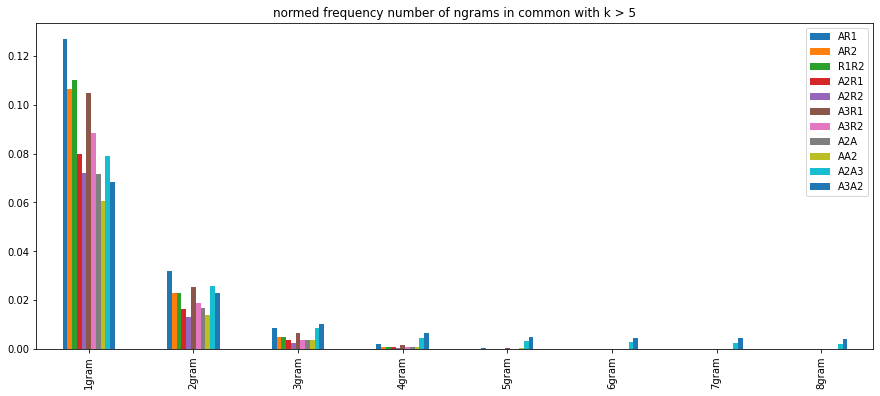

time: 471 ms (started: 2022-05-10 19:36:23 +02:00)


In [37]:
compareRep_list.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_all') #store = True by default

####  Comparelist for A2 & A3 
> same model different temperature:  
>  + A2 with temperature <= 1<br>
>  + A3 with temperature > 1

In [38]:
namelistA23 = ['A2R1', 'A2R2','A3R1', 'A3R2','A3A2','A2A3']
detail_listA23 = [detailA2R1, detailA2R2,detailA3R1, detailA3R2, detailA3A2,detailA2A3]

compareRep_listA23 = CorpusCompareList(detail_listA23[:-2],namelistA23[:-2] )
klist = compareRep_listA23.get_klist()
klist

[6, 8, -1, 8]

time: 6.03 ms (started: 2022-05-10 19:36:25 +02:00)


In [39]:
cover_allA23 = compareRep_listA23.get_cover_all( store = False) #store = True by default, will be stored in resFolder

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs R1,0.467368,0.306631,0.155178,0.076028,0.042746,0.027356,0.020314,0.016212
couverture_A2 vs R2,0.393133,0.209403,0.083077,0.028139,0.010302,0.004177,0.001779,0.000878
couverture_A3 vs R1,0.502624,0.384995,0.222024,0.126381,0.077851,0.052657,0.037908,0.029081
couverture_A3 vs R2,0.399300,0.237072,0.100798,0.037570,0.013022,0.005119,0.002008,0.000802


time: 19.2 ms (started: 2022-05-10 19:36:27 +02:00)


In [40]:
recouvrementA23 = compareRep_listA23.get_recouvrement(store = False)
recouvrementA23 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs R1,0.120264,0.043006,0.017529,0.007974,0.004382,0.002791,0.002081,0.001673
recouvrement_A2 vs R2,0.109593,0.031711,0.010399,0.003348,0.001216,0.000494,0.000212,0.000106
recouvrement_A3 vs R1,0.175237,0.079756,0.038368,0.020431,0.012335,0.008315,0.006009,0.004636
recouvrement_A3 vs R2,0.147466,0.051910,0.018937,0.006772,0.002337,0.000924,0.000365,0.000147


time: 16.1 ms (started: 2022-05-10 19:36:28 +02:00)


,A2R1,A2R2,A3R1,A3R2
1gram,0.040433,0.037508,0.070598,0.059196
2gram,0.026529,0.018420,0.054342,0.032960
3gram,0.013895,0.007852,0.031954,0.015000
4gram,0.007162,0.002842,0.018717,0.005955
5gram,0.004201,0.001093,0.011880,0.002139
6gram,0.002757,0.000468,0.008185,0.000870
7gram,0.002081,0.000208,0.005973,0.000361
8gram,0.001673,0.000106,0.004622,0.000147


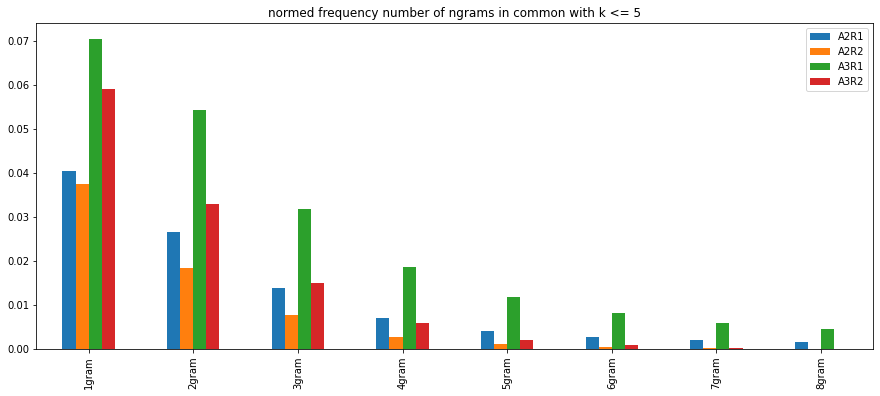

time: 308 ms (started: 2022-05-10 19:36:30 +02:00)


In [41]:
compareRep_listA23.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_A2A3') 

,A2R1,A2R2,A3R1,A3R2
1gram,0.079831,0.072085,0.104639,0.088270
2gram,0.016477,0.013290,0.025414,0.018950
3gram,0.003634,0.002547,0.006414,0.003937
4gram,0.000813,0.000506,0.001714,0.000817
5gram,0.000181,0.000122,0.000455,0.000199
6gram,0.000035,0.000027,0.000130,0.000054
7gram,0.000000,0.000004,0.000036,0.000004
8gram,0.000000,0.000000,0.000014,0.000000


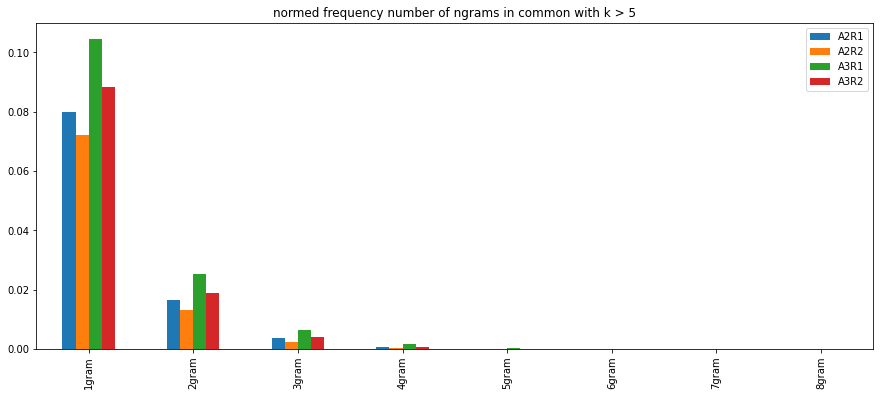

time: 314 ms (started: 2022-05-10 19:36:33 +02:00)


In [42]:
compareRep_listA23.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_A2A3') 

##### add A2A3, A3A2

In [43]:
for name, cp in zip(['A2A3', 'A3A2'], [detailA2A3, detailA3A2]):
    compareRep_listA23.add( cp, name )
klist = compareRep_listA23.get_klist()
klist

[6, 8, -1, 8, -1, -1]

time: 12.1 ms (started: 2022-05-10 19:36:35 +02:00)


In [44]:
cover_allA23 = compareRep_listA23.get_cover_all( store = False) #store = True by default, will be stored in resFolder

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs R1,0.467368,0.306631,0.155178,0.076028,0.042746,0.027356,0.020314,0.016212
couverture_A2 vs R2,0.393133,0.209403,0.083077,0.028139,0.010302,0.004177,0.001779,0.000878
couverture_A3 vs R1,0.502624,0.384995,0.222024,0.126381,0.077851,0.052657,0.037908,0.029081
couverture_A3 vs R2,0.399300,0.237072,0.100798,0.037570,0.013022,0.005119,0.002008,0.000802
couverture_A2 vs A3,0.424528,0.242074,0.124838,0.065029,0.039978,0.029764,0.024947,0.022506
couverture_A3 vs A2,0.300131,0.158416,0.078082,0.040121,0.024490,0.018157,0.015186,0.013705


time: 21.4 ms (started: 2022-05-10 19:36:35 +02:00)


In [45]:
recouvrementA23 = compareRep_listA23.get_recouvrement(store = False)
recouvrementA23 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs R1,0.120264,0.043006,0.017529,0.007974,0.004382,0.002791,0.002081,0.001673
recouvrement_A2 vs R2,0.109593,0.031711,0.010399,0.003348,0.001216,0.000494,0.000212,0.000106
recouvrement_A3 vs R1,0.175237,0.079756,0.038368,0.020431,0.012335,0.008315,0.006009,0.004636
recouvrement_A3 vs R2,0.147466,0.051910,0.018937,0.006772,0.002337,0.000924,0.000365,0.000147
recouvrement_A2 vs A3,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.009530,0.008591
recouvrement_A3 vs A2,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.009530,0.008591


time: 14.6 ms (started: 2022-05-10 19:36:35 +02:00)


,A2R1,A2R2,A3R1,A3R2,A2A3,A3A2
1gram,0.040433,0.037508,0.070598,0.059196,0.134219,0.145100
2gram,0.026529,0.018420,0.054342,0.032960,0.079974,0.082795
3gram,0.013895,0.007852,0.031954,0.015000,0.041696,0.040325
4gram,0.007162,0.002842,0.018717,0.005955,0.020810,0.018926
5gram,0.004201,0.001093,0.011880,0.002139,0.012070,0.010261
6gram,0.002757,0.000468,0.008185,0.000870,0.008551,0.006705
7gram,0.002081,0.000208,0.005973,0.000361,0.006981,0.005112
8gram,0.001673,0.000106,0.004622,0.000147,0.006300,0.004428


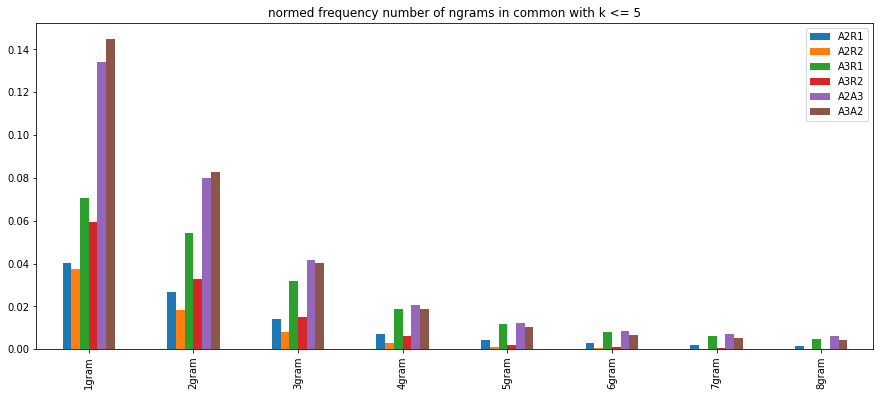

time: 358 ms (started: 2022-05-10 19:36:36 +02:00)


In [46]:
compareRep_listA23.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_A2A3') 

,A2R1,A2R2,A3R1,A3R2,A2A3,A3A2
1gram,0.079831,0.072085,0.104639,0.088270,0.079117,0.068237
2gram,0.016477,0.013290,0.025414,0.018950,0.025920,0.023098
3gram,0.003634,0.002547,0.006414,0.003937,0.008765,0.010135
4gram,0.000813,0.000506,0.001714,0.000817,0.004633,0.006518
5gram,0.000181,0.000122,0.000455,0.000199,0.003351,0.005160
6gram,0.000035,0.000027,0.000130,0.000054,0.002855,0.004701
7gram,0.000000,0.000004,0.000036,0.000004,0.002549,0.004418
8gram,0.000000,0.000000,0.000014,0.000000,0.002291,0.004163


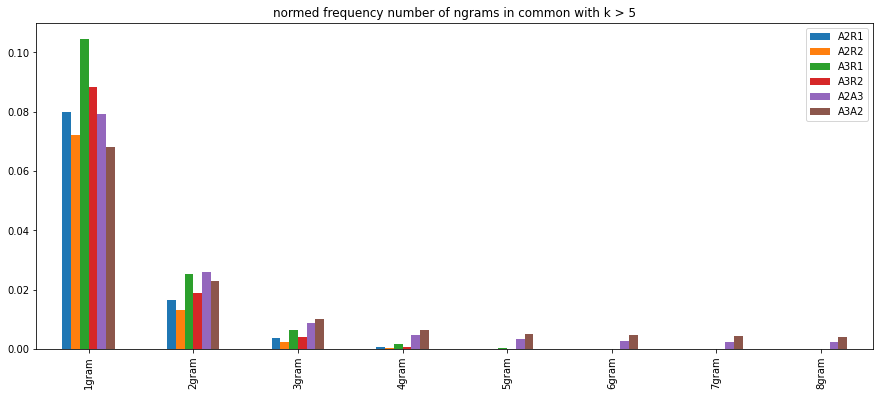

time: 479 ms (started: 2022-05-10 19:36:39 +02:00)


In [47]:
compareRep_listA23.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_A2A3') 

In [48]:
compareRep_listA23.add(detail_R12 , 'R1R2' )
klist = compareRep_listA23.get_klist()
klist

[6, 8, -1, 8, -1, -1, -1]

time: 4.31 ms (started: 2022-05-10 19:36:39 +02:00)


,A2R1,A2R2,A3R1,A3R2,A2A3,A3A2,R1R2
1gram,0.040433,0.037508,0.070598,0.059196,0.134219,0.145100,0.199118
2gram,0.026529,0.018420,0.054342,0.032960,0.079974,0.082795,0.109565
3gram,0.013895,0.007852,0.031954,0.015000,0.041696,0.040325,0.050783
4gram,0.007162,0.002842,0.018717,0.005955,0.020810,0.018926,0.021422
5gram,0.004201,0.001093,0.011880,0.002139,0.012070,0.010261,0.008568
6gram,0.002757,0.000468,0.008185,0.000870,0.008551,0.006705,0.003581
7gram,0.002081,0.000208,0.005973,0.000361,0.006981,0.005112,0.001625
8gram,0.001673,0.000106,0.004622,0.000147,0.006300,0.004428,0.000802


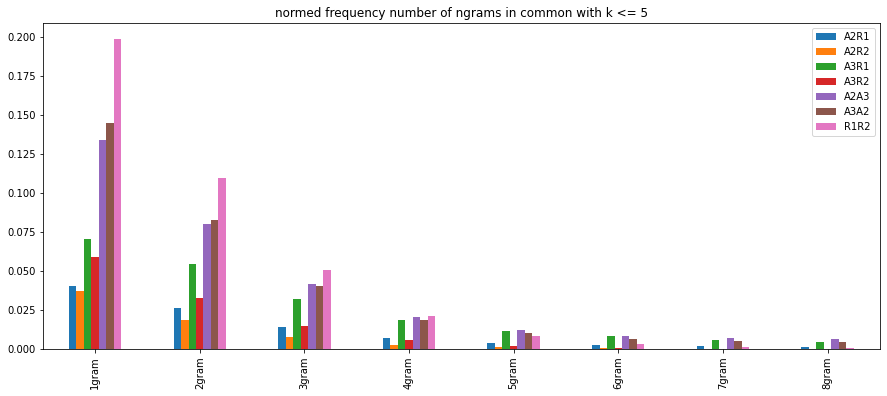

time: 409 ms (started: 2022-05-10 19:36:39 +02:00)


In [49]:
compareRep_listA23.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_A2A3_r12') 

,A2R1,A2R2,A3R1,A3R2,A2A3,A3A2,R1R2
1gram,0.079831,0.072085,0.104639,0.088270,0.079117,0.068237,0.110060
2gram,0.016477,0.013290,0.025414,0.018950,0.025920,0.023098,0.022915
3gram,0.003634,0.002547,0.006414,0.003937,0.008765,0.010135,0.004885
4gram,0.000813,0.000506,0.001714,0.000817,0.004633,0.006518,0.001036
5gram,0.000181,0.000122,0.000455,0.000199,0.003351,0.005160,0.000238
6gram,0.000035,0.000027,0.000130,0.000054,0.002855,0.004701,0.000060
7gram,0.000000,0.000004,0.000036,0.000004,0.002549,0.004418,0.000011
8gram,0.000000,0.000000,0.000014,0.000000,0.002291,0.004163,0.000005


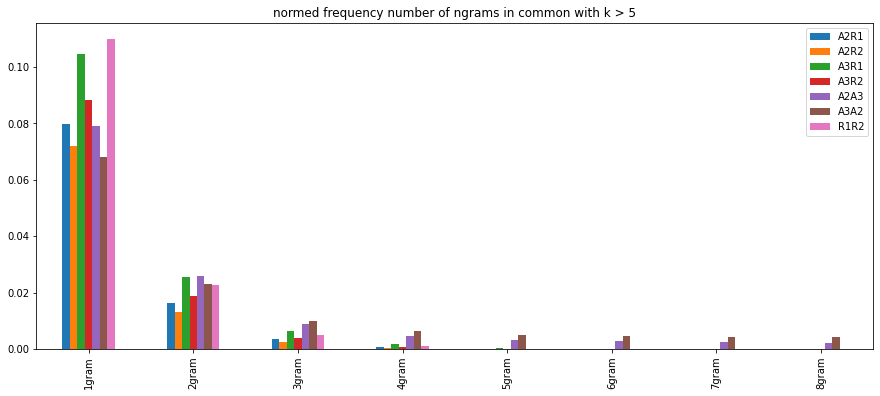

time: 368 ms (started: 2022-05-10 19:36:40 +02:00)


In [50]:
compareRep_listA23.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_A2A3_r12') 

####  Comparelist for artificial corpus
>A & A2 : different model with temperature<= 1
<br>
>A2 & A3: same model with different temperature range

In [51]:
compareRep_listA = CorpusCompareList([detailA2A, detailAA2, detailA3A, detailA2A3, detailA3A2], 
                                    ['A2A', 'AA2','A3A','A2A3','A3A2'])
compareRep_listA.get_klist()

[7, -1, 7, -1, -1]

time: 6.29 ms (started: 2022-05-10 19:36:42 +02:00)


In [52]:
cover_allA = compareRep_listA.get_cover_all(store = False) 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
couverture_A2 vs A,0.297247,0.132248,0.050417,0.018104,0.007227,0.003048,0.001186,0.000512
couverture_A vs A2,0.262031,0.085234,0.028773,0.009831,0.003843,0.001605,0.000624,0.000271
couverture_A3 vs A,0.289197,0.145596,0.063599,0.025707,0.010997,0.004797,0.001963,0.000713
couverture_A2 vs A3,0.424528,0.242074,0.124838,0.065029,0.039978,0.029764,0.024947,0.022506
couverture_A3 vs A2,0.300131,0.158416,0.078082,0.040121,0.024490,0.018157,0.015186,0.013705


time: 22.9 ms (started: 2022-05-10 19:36:42 +02:00)


In [53]:
recouvrementA = compareRep_listA.get_recouvrement(store = False)
recouvrementA 

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
recouvrement_A2 vs A,0.161798,0.054663,0.018660,0.006412,0.002515,0.001053,0.000409,0.000177
recouvrement_A vs A2,0.161798,0.054663,0.018660,0.006412,0.002515,0.001053,0.000409,0.000177
recouvrement_A3 vs A,0.191168,0.077868,0.031293,0.012181,0.005136,0.002228,0.000911,0.000332
recouvrement_A2 vs A3,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.009530,0.008591
recouvrement_A3 vs A2,0.213336,0.105893,0.050461,0.025444,0.015421,0.011406,0.009530,0.008591


time: 26.5 ms (started: 2022-05-10 19:36:43 +02:00)


In [54]:
#different model
detailA2A.get_len_all()[['len_all']].T

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_all,11879,40137,60556,70336,74745,76947,78202,78967


time: 7.36 ms (started: 2022-05-10 19:36:46 +02:00)


In [55]:
# different temperature
detailA2A3.get_len_all()[['len_all']].T

,1gram,2gram,3gram,4gram,5gram,6gram,7gram,8gram
len_all,12867,37925,55449,63670,67440,69350,70622,71585


time: 9.06 ms (started: 2022-05-10 19:36:46 +02:00)


,A2A,AA2,A3A,A2A3,A3A2
1gram,0.090327,0.101187,0.116291,0.134219,0.145100
2gram,0.038020,0.040835,0.058459,0.079974,0.082795
3gram,0.015093,0.015027,0.026501,0.041696,0.040325
4gram,0.005673,0.005445,0.010855,0.020810,0.018926
5gram,0.002288,0.002154,0.004719,0.012070,0.010261
6gram,0.000988,0.000923,0.002121,0.008551,0.006705
7gram,0.000396,0.000345,0.000901,0.006981,0.005112
8gram,0.000177,0.000139,0.000332,0.006300,0.004428


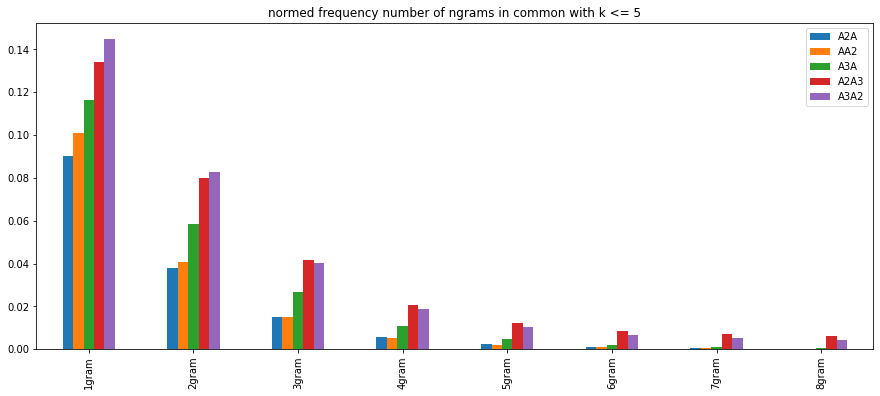

time: 376 ms (started: 2022-05-10 19:36:46 +02:00)


In [56]:
compareRep_listA.show_recouv_k5(mode = 'max', img_name = 'recouv_k<=5_A2A3A') 

,A2A,AA2,A3A,A2A3,A3A2
1gram,0.071471,0.060611,0.074877,0.079117,0.068237
2gram,0.016643,0.013828,0.019409,0.025920,0.023098
3gram,0.003567,0.003633,0.004792,0.008765,0.010135
4gram,0.000739,0.000967,0.001326,0.004633,0.006518
5gram,0.000227,0.000361,0.000418,0.003351,0.005160
6gram,0.000065,0.000130,0.000107,0.002855,0.004701
7gram,0.000013,0.000064,0.000010,0.002549,0.004418
8gram,0.000000,0.000038,0.000000,0.002291,0.004163


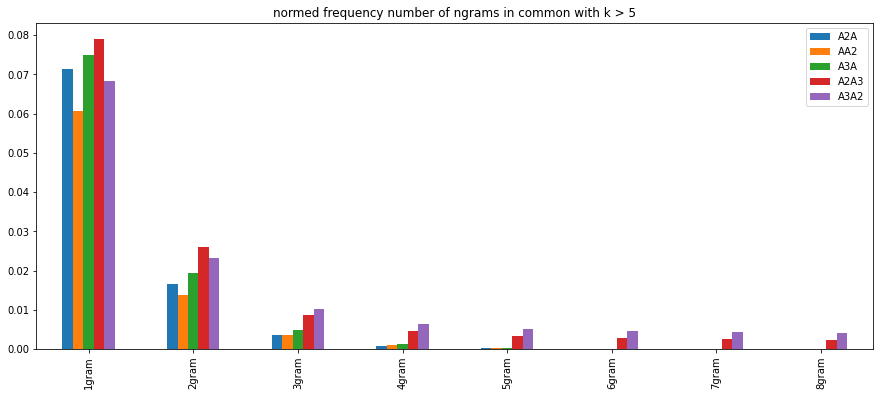

time: 328 ms (started: 2022-05-10 19:36:47 +02:00)


In [57]:
compareRep_listA.show_recouv_k5(mode = 'min', img_name = 'recouv_k>5_A2A3A') 

### Some other trial about common text to improve 
>get_common_text_singleN can find the common_text from a given ngram. 

>The result of this function may include some ngrams that is in **none of** both corpus, because we can have `head_token`+`may_common` and `may_common`+ `tail_token` in both corpus, but `head_token` + `may_common` + `tail_token` in none of them, even though if `head_token` + `may_common` + `tail_token` in both corpus then there must be `head_token + may_common` and `may_common + tail_token` in both corpus. <br>


In [85]:
text_tofind = list(detailAR1.get_detail()['8gram']['8gram'].values)
text_freq = list(detailAR1.get_detail()['8gram']['freq_c0'].values)
print('before:', len(text_freq))

#store = False by default. remember that this is a global function instead of a method,
#so we have to precise the resfolder if we want to put the result in it when store = True.
common_test1 = get_common_text_singleN(text_tofind, text_freq, 8) 
print('after', len(common_test1))
common_test1[:6] 

before: 367
after 227


['une patiente en mauvais état général apyrétique avec',
 "La patiente bénéficié d'une imagerie par résonance magnétique cérébrale IRM",
 'ans sans antécédents pathologiques particuliers qui présentait une',
 'Il agit un patient de 42 ans diabétique sous antidiabétiques oraux',
 'clinique retrouvait une patiente en mauvais état général',
 'mal limitée mobile par rapport au plan superficiel']

time: 144 ms (started: 2022-05-03 01:45:54 +02:00)


>check the longest match found by `get_common_text_singleN`, also find the concatenated texts that are in none of the corpus

In [86]:
corpusR1_text = ' '.join(tokenizer_fr(corpusR1_txt))
corpusA_text = ' '.join(tokenizer_fr(corpusA_txt))

time: 5.15 s (started: 2022-05-03 01:45:54 +02:00)


In [87]:
len_common_all1 = [len(x.split()) for x in common_test1 if x in corpusA_text and x in corpusR1_text ]
mid = max(len_common_all1)
print('n max :', mid)
#The longest ngram found by `get_common_text_singleN` are:
#We consider the difference between cases)
print(set([x for x in common_test1 if len(x.split()) == mid]))

print('\n=====#longest match found by `get_common_text_singleN`:')
print([x for x in common_test1 if len(x.split()) == mid and x in corpusA_text and x in corpusR1_text] )

n max : 15
{"Le tout évoluant dans un contexte d'apyrexie et de conservation de l'état général L'examen clinique", "le tout évoluant dans un contexte d'apyrexie et de conservation de l'état général L'examen clinique"}

=====#longest match found by `get_common_text_singleN`:
["Le tout évoluant dans un contexte d'apyrexie et de conservation de l'état général L'examen clinique"]
time: 98.3 ms (started: 2022-05-03 01:45:59 +02:00)


In [88]:
xxx = np.array(common_test1)
print("==========the concatenated text not in A:")
print(np.all([txt.lower() in corpusA_text.lower() for txt in common_test1 ]))
noA = xxx[np.where([txt.lower() not in corpusA_text.lower() for txt in common_test1 ])]
print([len(x.split()) for x in noA])
print(noA)

print("==========the concatenated text not in R1:")
print(np.all([txt.lower() in corpusR1_text.lower() for txt in common_test1 ]))
noR1 = xxx[np.where([txt.lower() not in corpusR1_text.lower() for txt in common_test1 ])]
print([len(x.split()) for x in noR1])
print(noR1)

==========the concatenated text not in A:
False
[9, 12, 10, 9]
['était admis aux urgences dans un tableau de cellulite'
 'de 65 ans sans antécédents pathologiques particuliers qui présenté il 10 mois'
 "L'examen clinique retrouvait une patiente en mauvais état général apyrétique"
 "évoluant dans un contexte d'altération de l'état général avec"]
==========the concatenated text not in R1:
False
[12, 9, 10, 10, 9]
["une patiente consciente et stable sur le plan hémodynamique et respiratoire L'examen"
 'était admis aux urgences dans un tableau de cellulite'
 'une VS 40 mm la première heure et la CRP'
 "L'examen clinique retrouvait une patiente en mauvais état général apyrétique"
 'et un arrêt des matières et des gaz Il']
time: 2.71 s (started: 2022-05-03 01:45:59 +02:00)


>As suggested by Nicolas maybe this is a way to find the longest match:

In [89]:
ttt = common_test1 .copy()#[x for x in common_test1 if x.lower() in corpusA_text.lower() and x.lower() in corpusR1_text.lower()]
aaa = get_common_text_singleN(ttt, [1]*len(ttt), 8)
print('max n:',len(aaa))
print(max([len(x.split()) for x in aaa if x in corpusA_text and x in corpusR1_text ]))

aaaa = get_common_text_singleN(aaa, [1]*len(aaa), 8)
print('max n:',len(aaaa))
print(max([len(x.split()) for x in aaaa if x in corpusA_text and x in corpusR1_text ]))

aaaaa = get_common_text_singleN(aaaa, [1]*len(aaaa), 8)
print('max n', len(aaaa))
print(max([len(x.split()) for x in aaaaa if x in corpusA_text and x in corpusR1_text ]))
set(aaaa)==set(aaaaa)

max n: 202
17
max n: 200
17
max n 200
17


True

time: 407 ms (started: 2022-05-03 01:46:02 +02:00)


In [90]:
print(set([x for x in aaaa if len(x.split()) == 17]))
pd.read_csv(resFolder+'/longest_matchAR1.tsv', sep = '\t', index_col = 0)

{'une formation hypoéchogène hétérogène de contours irréguliers renfermant des zones kystiques et prenant fortement le doppler couleur'}


,text_common,freq_c0,freq_c1
0,une formation hypoéchogène hétérogène de contours irréguliers renfermant des zones kystiques et prenant fortement le...,2,1


time: 7.85 ms (started: 2022-05-03 01:46:02 +02:00)
